# **Ocean Mixing Story Group 1**

## Background 

This project aims to better understand the statistical significance of reconstructing global pCO₂ fields using ML trained on sparse data. It extends upon the analysis carried out by **Gloege et al. (2021)** *"Quantifying Errors in Observationally Based Estimates of Ocean Carbon Sink Variability."* and the method of **Bennington et al. (2022)** *"Explicit Physical Knowledge in Machine Learning for Ocean Carbon Flux Reconstruction: The pCO2-Residual Method"* by introducing a new ML method, NGBoost, which gives a probablistic prediction instead of XGBoost's point prediction. By introducting probablistic information, including standard deviations, one can understand the statistical confidence of models and how that confidence changes with the introduction of additional data. 

Oceans have absorbed 38% of all anthropogenic fossil fuel emissions over the industrial era. Yet, the scientific communitity is uncertain whether oceans will continue to absorb the same amount of carbon. Accurate estimations of air–sea CO₂ flux are critical for understanding the current and future global carbon budget, but are challenging due to the sparse and unevenly distributed nature of surface ocean pCO₂ observations. 

Probablistic predictions provide better understanding of current models based on this sparse and uneven observations versus point-based predictions. By better understanding and confidence in pCO2 reconstructions, scientists can more accurately convey recommendations based on the models, such as more accurately answer questions related to carbon budgets and other scientific and socio-economic questions related to climate change. Additionally, this research can inform scientific funding, helping to answer whether more real-world pCO₂ observations are needed for more accurate models.   

## Goals 

This analysis has two goals:
1. Determine the **statistical confidence and variability** of the pCO₂ reconstructions across the globe
2. Investigate how **adding more observations** affects statistical confidence and variability

Results from this investigation will help answer where there is more variation in the data and likewise where there is greater confidence in the pCO₂ reconstructions.

Furthermore, this analysis will help answer the degree to which adding data will improve the confidence of reconstruction models generally. Going a step deeper, this investigation can give insight into whether it is more important to add more observations in locations historically sampled, or in locations not in the database. Relatedly, this research can inform which areas of the globe are most important to direct funding towards sampling, or to focus other statistical technique to improve model confidence. 

## ML model 

Both NGBoost and XGBoost are gradient boosting algorithms. NGBoost is a gradient boosting algorithm that focuses on probabilistic predictions and uncertainty estimation, while XGBoost is a general-purpose gradient boosting algorithm known for its accuracy and efficiency.

The NGBoost method is more resource intensive than XGBoost. As such, this analysis focuses on one ESM model and 3 members.

## Adding Observations

In section 2, there is an investigation of how adding data to the model affects statistical confidence and variability. In particular, we investigate adding data across 2 dimensions:

1. Adding more observations at locations that have historically been sampled. 
2. Adding new locations, not previously sampled for pCO2 concentrations.

In both methods, we investigate increasing sampling by 14%, 30%, and 50% compared to current observations. In 1., this research adds more observations to locations that have historically been sampled. In 2., this research focuses on adding new locations in 3 undersampled Ocean Basins: Southern Ocean, Indian Ocean, and Pacific Ocean between Australia and South America. (Arctic areas were not added given the lack of coverage in ESMs).   

## Key Findings

TO BE FILLED OUT

## Structure:

0. Setup
1. Understanding Surface pCO₂ Sampling
2. Training NGBoost Model
3. Stastistical Analysis of pCO₂ Reconstructions
4. Testing Additional Members
5. Conclusion

In [1]:
your_username = 'azamkhan99'  # username of the person running the code. Reviewers should also change this to their own username.

#To allow the reviewer to access the saved files, provide notebook owner's username here:  
owner_username = 'azamkhan99'  # Reviewer should not change this name

# 0. Setup Workspace and Import Packages


In [2]:
%%capture
!pip install tensorflow
!pip install keras

In [3]:
%%capture
### standard imports ###
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
### Python file with supporting functions ###
# standard imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
# Redirect all low-level stderr output
sys.stderr = open(os.devnull, 'w')

import datetime
from collections import defaultdict
import random
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth',100)
import csv
import cmocean as cm

# machine learning libraries
import xgboost as xgb     
from xgboost import XGBRegressor

# Change to the parent directory of the current working directory. (Run only once—otherwise it will keep moving up the directory tree)
os.chdir(os.path.dirname(os.getcwd()))
print("Current working directory:", os.getcwd())

# Python file with supporting functions
import lib.residual_utils as supporting_functions
from lib.visualization import *
from lib.bias_figure2 import concat_datasets, XarrayEvaluator
from lib.corr_figure3 import eval_spatial
import lib.functions as func
import lib.group1_utils as g1u

E0000 00:00:1745779788.009405   30849 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745779788.015045   30849 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745779788.029569   30849 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745779788.029589   30849 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745779788.029591   30849 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745779788.029592   30849 computation_placer.cc:177] computation placer already registered. Please check linka

In [4]:
### Setting the date range to unify the date type ###

# Define date range
date_range_start = '2004-01-01T00:00:00.000000000'
date_range_end = '2023-12-31T00:00:00.000000000'

# create date vector, adds 14 days to start & end
dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS')


init_date = str(dates[0].year) + format(dates[0].month,'02d')
fin_date = str(dates[-1].year) + format(dates[-1].month,'02d')

# 1. Surface ocean pCO2: A sparse data challenge

Analyze stastical metrics of real-world & theoretical sampling of pCO₂

## 1.1
### 🔹 Original Mask

- **`socat_mask_data`**  
  The baseline SOCAT sampling mask, showing where and when surface ocean pCO₂ has been measured.

---

In [5]:
def plot_mask(mask, title):
    with plt.style.context(plot_style):
        fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
        worldmap = SpatialMap2(fig=fig, region='world', 
                    cbar_mode='each',
                    colorbar=True,
                    cbar_location='bottom',
                    nrows_ncols=[1,1])
        
        vrange = [0, 144, 12]
        cmap = cm.cm.rain
        data = xr_add_cyclic_point(mask, cyclic_coord='xlon')
        data = data.assign_coords(xlon=(((data.xlon + 180) % 360) ))
        sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                        vrange=vrange[0:2], cmap=cmap, ax=0, linewidth_coast=0.5)
        
        col = worldmap.add_colorbar(sub, ax=0,extend='max')
        worldmap.set_cbar_xlabel(col, 'Number of months with data', fontsize=14)
        worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
        col.ax.tick_params(labelsize=12)
        worldmap.set_title(title, ax=0, fontsize=14)
        plt.show()
        # save figure
        fig.savefig(f"mask_{title}.png", dpi=300, bbox_inches='tight')


In [6]:
def plot_maskd(mask, title):
    with plt.style.context(plot_style):
        fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
        worldmap = SpatialMap2(fig=fig, region='world', 
                    cbar_mode='each',
                    colorbar=True,
                    cbar_location='bottom',
                    nrows_ncols=[1,1])
        
        vrange = [0, 20, 1]
        cmap = cm.cm.rain
        data = xr_add_cyclic_point(mask, cyclic_coord='xlon')
        data = data.assign_coords(xlon=(((data.xlon + 180) % 360) ))
        sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                        vrange=vrange[0:2], cmap=cmap, ax=0, linewidth_coast=0.5)
        
        col = worldmap.add_colorbar(sub, ax=0,extend='max')
        worldmap.set_cbar_xlabel(col, 'Number of months with data', fontsize=14)
        worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
        col.ax.tick_params(labelsize=12)
        worldmap.set_title(title, ax=0, fontsize=14)
        plt.show()
        # save figure
        fig.savefig(f"mask_{title}.png", dpi=300, bbox_inches='tight')

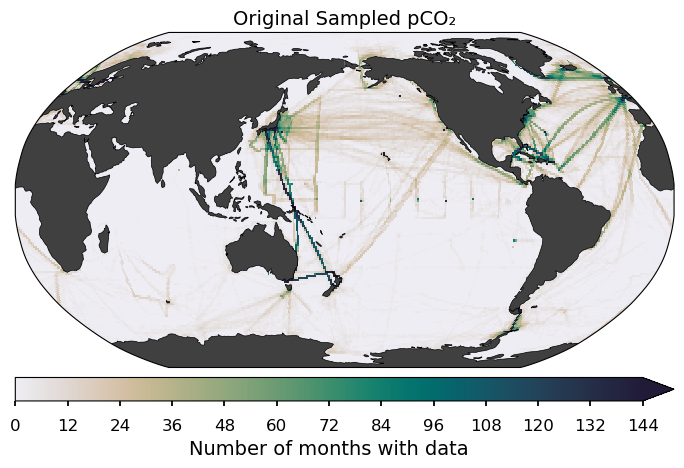

In [7]:
zarr_dir = 'gs://leap-persistent/abbysh/zarr_files_'
socat_path = f"{zarr_dir}/socat_mask_feb1982-dec2023.zarr"
socat_mask_data = xr.open_zarr(socat_path).sel(time=slice(str(dates[0]),str(dates[-1])))

non_zero_counts = (socat_mask_data.socat_mask != 0).sum(dim="time")
plot_style = "seaborn-v0_8-talk"

plot_mask(non_zero_counts, "Original Sampled pCO₂")

Here, we visualize all SOCAT data for the period selected for this analysis (default is 2004-2023) at each 1 degree X 1 degree location (100x100km at the equator). 

Data is sparse, with only around 2% of the globe sampled. The majority of the sampling is in the northern hemisphere

## 1.2
## Adding More Locations

This notebook investigates how different sampling strategies affect the statistical confidence of pCO₂ reconstructions.  

In both methods, we investigate samples increases of 14%, 30%, and 50%. "Augmenting existing locations" looks at adding more data to locations that have already been sampled historically, while "adding new locations" only looks to add data in places that have not historically been sampled. 

Given the methodology, both methods tend to add data outside of typical shipping routes, especially in the Southern Hemisphere. The "adding new locations" is more concentrated in the additions, while the new data in "augmenting existing" is more dispersed. 

---

### 1.2.1
### 🔸 Augmenting Existing Sampled Locations

These variants **increase the number of samples at already-sampled locations** without changing the spatial coverage.

- **`socat_mean_glob`**  
  Boosts under-sampled locations (below global mean) to the global mean number of sampling months (14% increase).

- **`socat_30p_glob`**  
  Ensures all existing sampled grid cells have at least 7 months of data (≈30% increase).

- **`socat_50p_glob`**  
  Ensures all existing sampled grid cells have at least 10 months of data (≈50% increase).

---

In [8]:
#Add more sampling to areas with low historical sampling
mean_val_glob_loc, socat_mean_glob, thirtyp_val_glob, socat_30p_glob, fiftyp_val_glob, socat_50p_glob = func.add_to_existing(non_zero_counts, socat_mask_data)

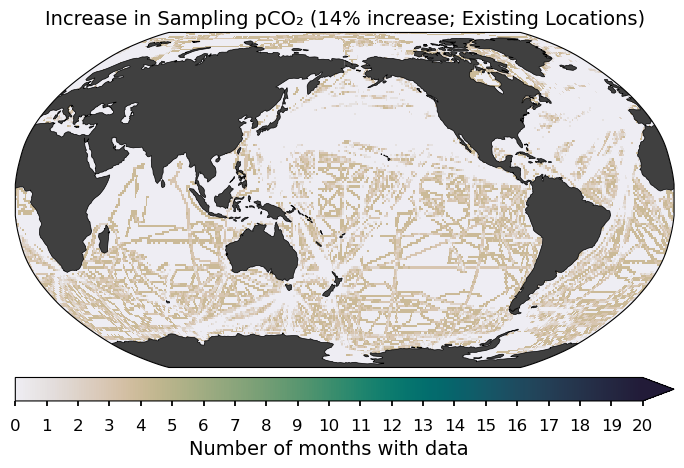

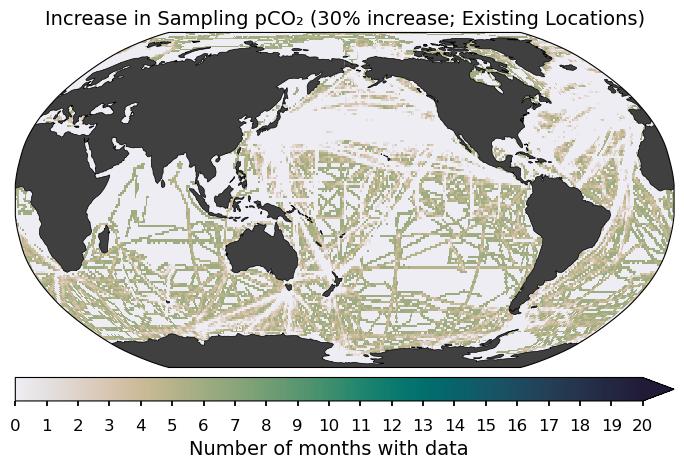

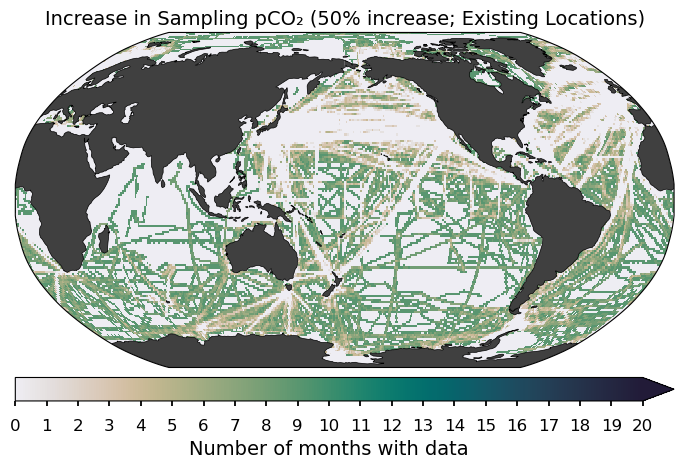

In [9]:
diff_mean = mean_val_glob_loc - non_zero_counts
diff_30p  = thirtyp_val_glob  - non_zero_counts
diff_50p  = fiftyp_val_glob   - non_zero_counts

#visualize increase in sampling
plot_maskd(diff_mean, "Increase in Sampling pCO₂ (14% increase; Existing Locations)")
plot_maskd(diff_30p, "Increase in Sampling pCO₂ (30% increase; Existing Locations)")
plot_maskd(diff_50p, "Increase in Sampling pCO₂ (50% increase; Existing Locations)")

### 1.2.2
### 🔸 Adding New Sample Locations

These variants **expand the spatial footprint** by adding sampling at new locations in undersampled ocean regions.

- **`addmeanp_socat`**  
  Adds ~14% new grid points in each of the three undersampled basins, sampled at the global mean frequency.

- **`add30p_socat`**  
  Adds 100 new grid points per basin, each with moderate sampling (~7 months).

- **`add50p_socat`**  
  Adds 200 new grid points per basin, each with higher sampling (~10 months).

---

<table style="border-collapse: collapse; width: 100%;">
  <tr>
    <th style="border: 1px solid black;">Region</th>
    <th style="border: 1px solid black;">Latitude Range</th>
    <th style="border: 1px solid black;">Longitude Range</th>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Pacific 1</td>
    <td style="border: 1px solid black;">-46 to -36</td>
    <td style="border: 1px solid black;">-97 to -87</td>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Pacific 2</td>
    <td style="border: 1px solid black;">-45 to -35</td>
    <td style="border: 1px solid black;">-130 to -110</td>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Pacific 3</td>
    <td style="border: 1px solid black;">-32 to -27</td>
    <td style="border: 1px solid black;">-141 to -121</td>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Southern Ocean</td>
    <td style="border: 1px solid black;">-76 to -67</td>
    <td style="border: 1px solid black;">-60 to -40</td>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Indian Ocean 1</td>
    <td style="border: 1px solid black;">-11 to 9</td>
    <td style="border: 1px solid black;">75 to 85</td>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Indian Ocean 2</td>
    <td style="border: 1px solid black;">-30 to -25</td>
    <td style="border: 1px solid black;">70 to 90</td>
  </tr>
</table>

In [10]:
addmeanp_oceans, addmeanp_socat, add30p_oceans, add30p_socat, add50p_oceans, add50p_socat = func.add_new(non_zero_counts, socat_mask_data)


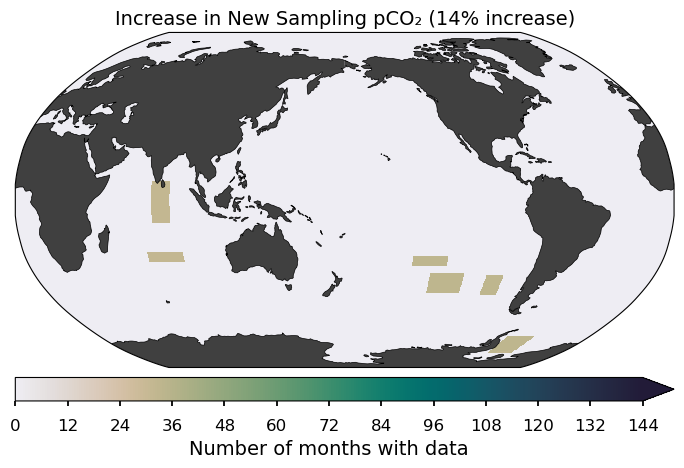

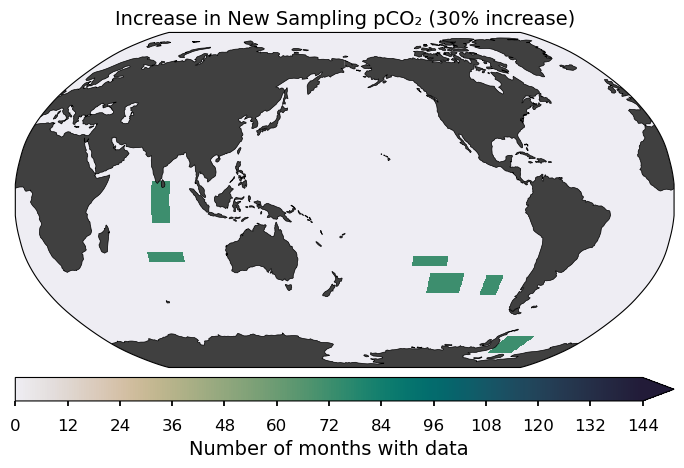

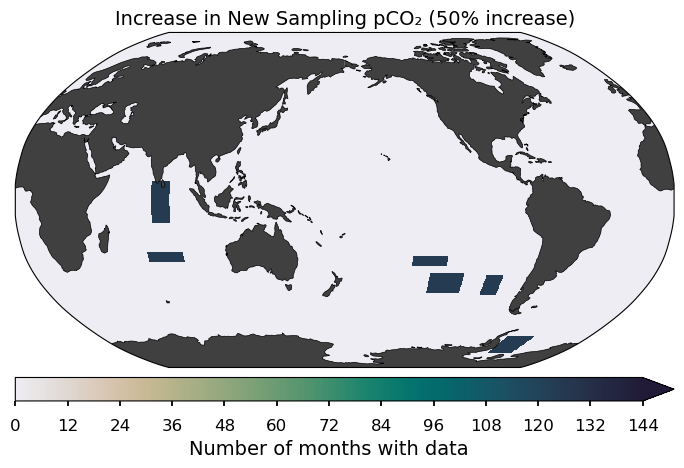

In [11]:
diff_mean_n = addmeanp_oceans - non_zero_counts
diff_30p_n  = add30p_oceans  - non_zero_counts
diff_50p_n  = add50p_oceans   - non_zero_counts

#visualize increase in sampling
plot_mask(diff_mean_n, "Increase in New Sampling pCO₂ (14% increase)")
plot_mask(diff_30p_n, "Increase in New Sampling pCO₂ (30% increase)")
plot_mask(diff_50p_n, "Increase in New Sampling pCO₂ (50% increase)")

In [12]:
mask_data_dict = {
    "baseline": socat_mask_data,
    "densify_mean_pattern": socat_mean_glob,
    "densify_30p": socat_30p_glob,
    "densify_50p": socat_50p_glob,
    "expand_14p": addmeanp_socat,
    "expand_30p": add30p_socat,
    "expand_50p": add50p_socat,
}


In [13]:
non_zero_dict = {
    "baseline" : non_zero_counts,
    "densify_mean_pattern": mean_val_glob_loc,
    "densify_30p": thirtyp_val_glob,
    "densify_50p": fiftyp_val_glob,
    "expand_14p": addmeanp_oceans,
    "expand_30p": add30p_oceans,
    "expand_50p": add50p_oceans
    
}

# 2. NGBoost Model Training

### 2.1 Training with NGBoost on observations

In [14]:
%%capture
!pip install --upgrade ngboost
from ngboost.scores import LogScore

In [15]:
# features for ML:
features_sel = [
    "sst",
    "sst_anom",
    "sss",
    "sss_anom",
    "mld_clim_log",
    "chl_log",
    "chl_log_anom",
    "xco2",
    "A",
    "B",
    "C",
    "T0",
    "T1",
]

# the target variable we reconstruct:
target_sel = [
    "pco2_residual"
]  # this represents pCO2 - pCO2-T (calculated in notebook 00)


In [16]:
### train-validate-test split proportions ###

select_dates = []
test_dates = []

for i in range(0, len(dates)):
    if i % 5 != 0:
        select_dates.append(dates[i])  ### 80% train days set ###
    if i % 5 == 0:
        test_dates.append(dates[i])  ### 20% test days set ###

### Then, the month numbers above are converted back to their respective datetime objects.

year_mon = []

for i in range(0, len(select_dates)):
    tmp = select_dates[i]
    year_mon.append(f"{tmp.year}-{tmp.month}")

test_year_mon = []

for i in range(0, len(test_dates)):
    tmp = test_dates[i]
    test_year_mon.append(f"{tmp.year}-{tmp.month}")


In [28]:
path_seeds = (
    "gs://leap-persistent/abbysh/pickles/random_seeds.npy"  # random seeds for ML
)
grid_search_approach = "nmse"
MLinputs_path = "gs://leap-persistent/Mukkke/pco2_residual/post01_xgb_inputs"
output_dir = f"gs://leap-persistent/{your_username}/{owner_username}/pco2_residual/{grid_search_approach}/post02_xgb"  # where to save machine learning results
metrics_output_dir = f"{output_dir}/metrics"  # where to save performance metrics
test_perform_fname = f"{metrics_output_dir}/ngb_test_performance_{init_date}-{fin_date}.csv"  # path for test performance metrics

In [24]:
ngb_params = {
    "n_estimators": 500,  # Number of boosting rounds
    "learning_rate": 0.05,  # Learning rate
    "natural_gradient": True,  # Use natural gradient
    "minibatch_frac": 0.8,  # Proportion of data used per iteration
    "col_sample": 0.8,  # Feature proportion per tree
    "verbose": True,  # Disable training output
    "Score": LogScore,  # Loss function
    "early_stopping_rounds": 25,  # Early stopping rounds
}


In [25]:
selected_mems_dict = {
    "ACCESS-ESM1-5": ["member_r10i1p1f1", "member_r5i1p1f1", "member_r2i1p1f1"],
}


In [26]:
mask_data_dict = {
     "baseline": socat_mask_data,
     "densify_mean_pattern": socat_mean_glob,
     "densify_30p": socat_30p_glob,
     "densify_50p": socat_50p_glob,
     "expand_14p": addmeanp_socat,
     "expand_30p": add30p_socat,
     "expand_50p": add50p_socat
}

In [30]:
# Call the function
g1u.run_ngboost_with_masks(
    mask_data_dict=mask_data_dict,
    selected_mems_dict=selected_mems_dict,
    features_sel=features_sel,
    target_sel=target_sel,
    year_mon=year_mon,
    test_year_mon=test_year_mon,
    path_seeds=path_seeds,
    MLinputs_path=MLinputs_path,
    init_date=init_date,
    fin_date=fin_date,
    output_dir=metrics_output_dir,
    params=ngb_params,  # NGBoost parameters
    runthiscell=-1,  # -1 = first member of first ensemble only (use 1 to run all)
#    your_username=your_username,  # username of the person running the code. Reviewer should also change this to their own username.
)


 

    dates,
    init_date,
    fin_date,
    output_dir,
    params,
    runthiscell=-1,

TypeError: run_ngboost_with_masks() missing 2 required positional arguments: 'dates' and 'output_dir'

In [ ]:
stop here

### 2.2 Reconstruction pCO₂ using ESMs

In [ ]:
seed_loc_dict = defaultdict(dict)
for ens, mem_list in selected_mems_dict.items():
    sub_dictt = {mem: no for no, mem in enumerate(mem_list)}
    seed_loc_dict[ens] = sub_dictt

In [157]:
fs = gcsfs.GCSFileSystem()
def run_reconstruction_with_masks(
    mask_data_dict,
    selected_mems_dict,
    features_sel,
    target_sel,
    year_mon,
    test_year_mon,
    seed_loc_dict,
    MLinputs_path,
    init_date,
    fin_date,
    dates,
    runthiscell=1,
    username=None,
):
    if runthiscell == -1:
        print(
            "Reviewing process: Running reconstruction only for the first member of the first ESM. \n"
            "Running reconstruction only for the first mask."
        )
        first_ens = list(selected_mems_dict.keys())[0]
        first_mem = selected_mems_dict[first_ens][0]
        run_selected_mems_dict = {first_ens: [first_mem]}
        first_mask = list(mask_data_dict.keys())[0]
        run_selected_mask_data_dict = {first_mask: mask_data_dict[first_mask]}
    else:
        print(
            "Running reconstruction for all members of all ESMs and all masks. \n"
            "This may take a while."
        )
        run_selected_mems_dict = selected_mems_dict
        run_selected_mask_data_dict = mask_data_dict
        
    # Save summary of mask coverage
    summary_rows = []
    for mask_name, mask_data in run_selected_mask_data_dict.items():
        print(f"\nRunning reconstruction for mask: {mask_name}\n")

        for ens, mem_list in run_selected_mems_dict.items():
            for member in mem_list:
                print(ens, member)
                seed_loc = seed_loc_dict[ens][member]
                data_dir = f"{MLinputs_path}/{ens}/{member}"
                fname = f"MLinput_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.pkl"
                file_path = f"{data_dir}/{fname}"

                # Load the model
                model_filename = f"{mask_name}_model_pCO2_2D_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.p"
                if username:
                    model_path = f"gs://leap-persistent/{username}/models/{model_filename}"
                    with fs.open(model_path, "rb") as f:
                        model = pickle.load(f)
                    print(f"Model loaded from GCS at: {model_path}")

                else:
                    local_output_dir = "output/model_saved"
                    model_path = Path(local_output_dir) / model_filename

                    with open(model_path, "rb") as f:
                        model = pickle.load(f)
                    print(f"Model loaded from local path: {model_path}")

                

                with fs.open(file_path, "rb") as filee:
                    df = pd.read_pickle(filee)
                    df["year"] = df.index.get_level_values("time").year
                    df["mon"] = df.index.get_level_values("time").month
                    df["year_month"] = (
                        df["year"].astype(str) + "-" + df["mon"].astype(str)
                    )

                    # print df['socat_mask'] stats before applying new mask
                    print(df['socat_mask'].describe())

                    # Replace socat_mask with the new mask
                    apply_socat_mask_inplace(df, mask_data)
                    print("Applied new SOCAT mask")

                    # print df['socat_mask'] stats after applying new mask
                    print(df['socat_mask'].describe())

                    recon_sel = (
                        ~df[features_sel + target_sel + ["net_mask"]].isna().any(axis=1)
                    ) & (
                        (df[target_sel] < 250) & (df[target_sel] > -250)
                    ).to_numpy().ravel()

                    sel = recon_sel & (df["socat_mask"] == 1)
                    train_sel = (
                        (sel & (pd.Series(df["year_month"]).isin(year_mon)))
                        .to_numpy()
                        .ravel()
                    )
                    test_sel = (
                        (sel & (pd.Series(df["year_month"]).isin(test_year_mon)))
                        .to_numpy()
                        .ravel()
                    )
                    unseen_sel = recon_sel & (df["socat_mask"] == 0)

                    print(f"Total selected locations for training ({mask_name}):", sel.sum())
                    print(f"Total unseen locations ({mask_name}):", unseen_sel.sum())


                    X = df.loc[sel, features_sel].to_numpy()
                    y = df.loc[sel, target_sel].to_numpy().ravel()

                y_pred_unseen = model.predict(
                    df.loc[unseen_sel, features_sel].to_numpy()
                )
                y_dists_unseen = model.pred_dist(
                    df.loc[unseen_sel, features_sel].to_numpy()
                )
                y_unseen = df.loc[unseen_sel, target_sel].to_numpy().ravel()

                unseen_performance = defaultdict(dict)
                unseen_performance[ens][member] = supporting_functions.evaluate_test(
                    y_unseen, y_pred_unseen
                )

                fields = unseen_performance[ens][member].keys()
                unseen_row_dict = {"model": ens, "member": member, "mask": mask_name}
                for field in fields:
                    unseen_row_dict[field] = unseen_performance[ens][member][field]

                unseen_perform_fname = f"{metrics_output_dir}/ngb_unseen_performance_{mask_name}_{init_date}-{fin_date}.csv"  # path for unseen performance metrics

                file_exists = fs.exists(unseen_perform_fname)
                with fs.open(unseen_perform_fname, "a") as f_object:
                    writer = csv.DictWriter(f_object, fieldnames=unseen_row_dict.keys())
                    if not file_exists:
                        writer.writeheader()
                    writer.writerow(unseen_row_dict)

                print(f"unseen performance metrics for {mask_name}:", unseen_performance[ens][member])

                y_pred_seen = model.predict(X)
                y_dists_seen = model.pred_dist(X)

                df["pCO2_recon_full"] = np.nan
                df.loc[unseen_sel, "pCO2_recon_full"] = y_pred_unseen
                df.loc[unseen_sel, "pCO2_recon_full_mean"] = y_dists_unseen.loc
                df.loc[unseen_sel, "pCO2_recon_full_std"] = y_dists_unseen.scale
                df.loc[sel, "pCO2_recon_full"] = y_pred_seen
                df.loc[sel, "pCO2_recon_full_mean"] = y_dists_seen.loc
                df.loc[sel, "pCO2_recon_full_std"] = y_dists_seen.scale

                df["pCO2_recon_unseen"] = np.nan
                df.loc[unseen_sel, "pCO2_recon_unseen"] = y_pred_unseen
                df.loc[unseen_sel, "pCO2_recon_unseen_mean"] = y_dists_unseen.loc
                df.loc[unseen_sel, "pCO2_recon_unseen_std"] = y_dists_unseen.scale
                df.loc[sel, "pCO2_recon_unseen"] = np.nan

                df["pCO2_truth"] = df.loc[:, target_sel]

                DS_recon = df[
                    [
                        "net_mask",
                        "socat_mask",
                        "pCO2_recon_full",
                        "pCO2_recon_unseen",
                        "pCO2_truth",
                        "pCO2_recon_full_mean",
                        "pCO2_recon_full_std",
                        "pCO2_recon_unseen_mean",
                        "pCO2_recon_unseen_std",
                    ]
                ].to_xarray()
                recon_output_dir = f"{output_dir}/reconstructions/{mask_name}"
                supporting_functions.save_recon(
                    DS_recon, dates, recon_output_dir, ens, member
                )

                

                summary_rows.append(
                    {
                        "mask": mask_name,
                        "member": member,
                        "seen_count": int(sel.sum()),
                        "unseen_count": int(unseen_sel.sum()),
                    }
                )
    pd.DataFrame(summary_rows).to_csv(
        f"{metrics_output_dir}/mask_coverage_summary.csv", index=False
    )

    print("end of all members", datetime.datetime.now())


In [271]:
run_reconstruction_with_masks(
    mask_data_dict=mask_data_dict,
    selected_mems_dict=selected_mems_dict,
    features_sel=features_sel,
    target_sel=target_sel,
    year_mon=year_mon,
    test_year_mon=test_year_mon,
    seed_loc_dict=seed_loc_dict,
    MLinputs_path=MLinputs_path,
    init_date=init_date,
    fin_date=fin_date,
    dates=dates,
    runthiscell=-1,  # -1 = first member of first ensemble only (use 1 to run all)
    username=your_username,  # username of the person running the code. Reviewer should also change this to their own username.
)

Reviewing process: Running reconstruction only for the first member of the first ESM. 
Running reconstruction only for the first mask.

Running reconstruction for mask: baseline

ACCESS-ESM1-5 member_r10i1p1f1
Model loaded from GCS at: gs://leap-persistent/azamkhan99/models/baseline_model_pCO2_2D_ACCESS-ESM1-5_r10i1p1f1_mon_1x1_200401_202312.p
count    1.555200e+07
mean     1.846200e-02
std      1.346148e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: socat_mask, dtype: float64
Applied new SOCAT mask
count    1.555200e+07
mean     1.846200e-02
std      1.346148e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: socat_mask, dtype: float64
Total selected locations for training (baseline): 223875
Total unseen locations (baseline): 7859225
unseen performance metrics for baseline: {'mse': 182.78102495652192, 'mae': 8.838994237415744, 'medae': np.float6

### 2.3 Inverse Residual Transformation

In [160]:
def calc_recon_pco2(
    regridded_members_dir,
    pco2_recon_dir,
    selected_mems_dict,
    mask_name,
    init_date,
    fin_date,
    owner_name=None,
):
    """
    Calculates reconstructed pco2 per member.

    Parameters
    ----------
    regridded_members_dir : str
        Path to regridded data from notebook 00, which contains pco2T.

    pco2_recon_dir : str
        Path to directory where ML reconstructions from notebook 02 are saved.
    """
    init_date_sel = pd.to_datetime(init_date, format="%Y%m")
    fin_date_sel = pd.to_datetime(fin_date, format="%Y%m")

    if owner_name:
        print(
            "Reviewing process: Running ML only for the first member of the first ESM, loading remaining reconstructed data from the notebook owner."
        )
        first_ens = list(selected_mems_dict.keys())[0]  # Get the first ensemble key
        first_mem = selected_mems_dict[first_ens][
            0
        ]  # Get the first member in that ensemble
        run_selected_mems_dict = {
            first_ens: [first_mem]
        }  # Create a dictionary with only the first ensemble and member
        
        grid_search_approach = "nmse"
        owener_output_dir = f"gs://leap-persistent/{owner_name}/{owner_name}/pco2_residual/{grid_search_approach}/post02_xgb"  # where to save machine learning results
        owener_recon_output_dir = f"{owener_output_dir}/reconstructions/{mask_name}"  # where owner save ML reconstructions

    else:
        run_selected_mems_dict = selected_mems_dict

    for ens, mem_list in run_selected_mems_dict.items():
        print(f"Current ESM: {ens}")

        for member in mem_list:
            print(f"On member {member}")

            ### File paths ###

            ### Path to regridded data from notebook 00, so we can get the pCO2-T we calculated in 00
            ### pCO2-T calculated from model pCO2 and SST
            pco2T_path = f"{regridded_members_dir}/{ens}/{member}/{ens}.{member.split('_')[-1]}.Omon.zarr"
            print("pco2T path:", pco2T_path)

            
            
            ### Path to reconstruction (ML output from notebook 02), where pCO2-residual was reconstructed
            pCO2R_path = f"{pco2_recon_dir}/{ens}/{member}/recon_pCO2residual_{ens}_{member}_mon_1x1_{init_date}_{fin_date}.zarr"
            print("pCO2R path:", pCO2R_path)

            ### Path to save calculated pCO2 (reconstructed pCO2-residual PLUS pCO2-T: Total pCO2 =  pCO2-residual + pCO2-T)
            file_out = f"{pco2_recon_dir}/{ens}/{member}/recon_pCO2_{ens}_{member}_mon_1x1_{init_date}_{fin_date}.zarr"  # change this to just pco2
            print("save path:", file_out)

            ### Loading pCO2-T and reconstructed pCO2-residual:
            pco2T_series = (
                xr.open_zarr(pco2T_path)
                .pco2_T.transpose("time", "ylat", "xlon")
                .sel(time=slice(init_date_sel, fin_date_sel))
            )
            pco2_ml_output = xr.open_zarr(
                pCO2R_path
            )  # , consolidated=False, storage_options={"token": "cloud"}, group=None)

            ### unseen reconstructed pCO2-Residual from XGB
            pCO2R_unseen_series = pco2_ml_output.pCO2_recon_unseen.transpose(
                "time", "ylat", "xlon"
            )

            pCO2R_unseen_means_series = pco2_ml_output.pCO2_recon_unseen_mean.transpose(
                "time", "ylat", "xlon"
            )
            pCO2R_unseen_stds_series = pco2_ml_output.pCO2_recon_unseen_std.transpose(
                "time", "ylat", "xlon"
            )

            ### Full (seen and unseen) reconstructed pCO2-Residual from XGB
            pCO2R_full_series = pco2_ml_output.pCO2_recon_full.transpose(
                "time", "ylat", "xlon"
            )

            pCO2_full_means_series = pco2_ml_output.pCO2_recon_full_mean.transpose(
                "time", "ylat", "xlon"
            )

            pCO2_full_stds_series = pco2_ml_output.pCO2_recon_full_std.transpose(
                "time", "ylat", "xlon"
            )

            # ### training set for pco2 residual
            # pCO2R_train_series = pco2_ml_output.pCO2_recon_train.transpose("time","ylat","xlon")

            # ### testing set for pco2 residual
            # pCO2R_test_series = pco2_ml_output.pCO2_recon_test.transpose("time","ylat","xlon")

            pCO2R_truth = pco2_ml_output.pCO2_truth.transpose("time", "ylat", "xlon")

            ### Get time coordinate correct
            pco2T_series = pco2T_series.assign_coords(
                {"time": ("time", pCO2R_unseen_series.time.data)}
            )

            ### Total pCO2 =  pCO2-residual + pCO2-T
            pco2_unseen = pco2T_series + pCO2R_unseen_series
            pco2_unseen_means = pco2T_series + pCO2R_unseen_means_series
            pco2_unseen_stds = pco2T_series + pCO2R_unseen_stds_series
            pco2_full = pco2T_series + pCO2R_full_series
            pco2_full_means = pco2T_series + pCO2_full_means_series
            pco2_full_stds = pco2T_series + pCO2_full_stds_series
            # pco2_train =  pco2T_series + pCO2R_train_series
            # pco2_test =  pco2T_series + pCO2R_test_series
            pco2_truth = pco2T_series + pCO2R_truth

            ### Creating xarray of pco2 ML output, but with temperature added back
            comp = xr.Dataset(
                {
                    "pCO2_recon_unseen": (["time", "ylat", "xlon"], pco2_unseen.data),
                    "pCO2_recon_full": (["time", "ylat", "xlon"], pco2_full.data),
                    "pCO2_recon_unseen_mean": (
                        ["time", "ylat", "xlon"],
                        pco2_unseen_means.data,
                    ),
                    "pCO2_recon_unseen_std": (
                        ["time", "ylat", "xlon"],
                        pco2_unseen_stds.data,
                    ),
                    "pCO2_recon_full_mean": (
                        ["time", "ylat", "xlon"],
                        pco2_full_means.data,
                    ),
                    "pCO2_recon_full_std": (
                        ["time", "ylat", "xlon"],
                        pco2_full_stds.data,
                    ),
                    # 'pCO2_recon_train': (["time","ylat","xlon"], pco2_train.data),
                    # 'pCO2_recon_train':(["time","ylat","xlon"],pco2_train.data),
                    # 'pCO2_recon_test':(["time","ylat","xlon"],pco2_test.data),
                    "pCO2_truth": (["time", "ylat", "xlon"], pco2_truth.data),
                },
                coords={
                    "time": (["time"], pco2T_series.time.values),
                    "xlon": (["xlon"], pco2T_series.xlon.values),
                    "ylat": (["ylat"], pco2T_series.ylat.values),
                },
            )

            ### to overwrite file if it exists already
            if fs.exists(file_out):
                fs.rm(file_out, recursive=True)

            ### for saving:
            comp = comp.chunk({"time": 100, "ylat": 45, "xlon": 90})
            comp.to_zarr(file_out, mode="w", zarr_format=2)

            print(f"finished with {member}")

    if owner_name:
        print("Copying remaining members from owner’s directory...")
        for ens, mem_list in selected_mems_dict.items():
            print(f"On member {member}")
            if ens in run_selected_mems_dict:
                remaining_members = [
                    m for m in mem_list if m not in run_selected_mems_dict[ens]
                ]
            else:
                remaining_members = mem_list

            for member in remaining_members:
                owner_file_out = f"{owener_recon_output_dir}/{ens}/{member}/recon_pCO2_{ens}_{member}_mon_1x1_{init_date}_{fin_date}.zarr"
                target_file_out = f"{pco2_recon_dir}/{ens}/{member}/recon_pCO2_{ens}_{member}_mon_1x1_{init_date}_{fin_date}.zarr"

                if fs.exists(owner_file_out):
                    print(f"Copying {owner_file_out} → {target_file_out}")
                    fs.copy(owner_file_out, target_file_out)
                else:
                    print(f"Warning: {owner_file_out} not found. Skipping.")
                print(f"finished with {member}")


In [161]:
ensemble_dir = "gs://leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members"  # path to regridded data
# recon_output_dir = f"{output_dir}/reconstructions/{mask_name}"  # where to save reconstructions

In [272]:
runthiscell = -1  # 0 will turn off, 1 will turn on, -1 will only run first member

if runthiscell:
    # Use the first masks if only testing with the first ensemble member
    if runthiscell == -1:
        first_mask = list(mask_data_dict.keys())[0]
        run_selected_mask_data_dict = {first_mask: mask_data_dict[first_mask]}
    else:
        run_selected_mask_data_dict = mask_data_dict

    for mask_name, mask_data in run_selected_mask_data_dict.items():
        print(f"Processing mask: {mask_name}")

        calc_recon_pco2(
            regridded_members_dir=ensemble_dir,
            pco2_recon_dir=f"{output_dir}/reconstructions/{mask_name}",
            selected_mems_dict=selected_mems_dict,
            mask_name=mask_name,
            init_date=init_date,
            fin_date=fin_date,
            owner_name=your_username if runthiscell == -1 else None,
        )

        print(f"Finished processing mask: {mask_name}")


Processing mask: baseline
Reviewing process: Running ML only for the first member of the first ESM, loading remaining reconstructed data from the notebook owner.
Current ESM: ACCESS-ESM1-5
On member member_r10i1p1f1
pco2T path: gs://leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members/ACCESS-ESM1-5/member_r10i1p1f1/ACCESS-ESM1-5.r10i1p1f1.Omon.zarr
pCO2R path: gs://leap-persistent/azamkhan99/azamkhan99/pco2_residual/nmse/post02_xgb/reconstructions/baseline/ACCESS-ESM1-5/member_r10i1p1f1/recon_pCO2residual_ACCESS-ESM1-5_member_r10i1p1f1_mon_1x1_200401_202312.zarr
save path: gs://leap-persistent/azamkhan99/azamkhan99/pco2_residual/nmse/post02_xgb/reconstructions/baseline/ACCESS-ESM1-5/member_r10i1p1f1/recon_pCO2_ACCESS-ESM1-5_member_r10i1p1f1_mon_1x1_200401_202312.zarr
finished with member_r10i1p1f1
Copying remaining members from owner’s directory...
On member member_r10i1p1f1
finished with member_r5i1p1f1
finished with member_r2i1p1f1
Finished processing mask: baseline

In [273]:
from google.cloud import storage

if runthiscell != -1:
    client = storage.Client()
    bucket = client.bucket("leap-persistent")

    for mask_name, mask_data in mask_data_dict.items():
        print(f"Processing mask: {mask_name}")

        # Define the prefix for the blobs you want to make public
        prefix = f"{your_username}/{your_username}/pco2_residual/nmse/post02_xgb/reconstructions/{mask_name}/"
        blobs = bucket.list_blobs(prefix=prefix)

        seen_dirs = (
            set()
        )
        # Track top-level directories (immediate subdirectories of `reconstructions`)
        for blob in blobs:
            # Extract the relative path after `reconstructions/`
            relative_path = blob.name[len(prefix) :]
            top_level_dir = relative_path.split("/")[0]
            # print(relative_path)


            # Get first component
            try:
                # Make the file public
                blob.make_public()

                # Only print if it's a new top-level directory
                if top_level_dir not in seen_dirs:
                    seen_dirs.add(top_level_dir)
                    print(f"Made public: {top_level_dir}")
                    # print(seen_dirs)
            except Exception as e:
                print(f"Failed to make public: {blob.name}")
                print(e)


Visualization of Reconstructions

In [200]:
def plot_reconstruction_vs_truth(
    mask_name,
    mask_data_dict,
    selected_mems_dict,
    ensemble_dir,
    output_dir,
    dates,
    init_date,
    fin_date,
    plot_style="seaborn-v0_8-talk",
    cmap=None,
    vrange=[280, 440],
    chosen_time="2021-01",
):
    import matplotlib.pyplot as plt
    import cmocean.cm as cm
    import numpy as np
    import xarray as xr

    if cmap is None:
        cmap = cm.thermal

    # Select the first ensemble and member
    first_ens = list(selected_mems_dict.keys())[0]
    first_mem = selected_mems_dict[first_ens][0]

    # Load original member data from ESM output
    member_dir = f"{ensemble_dir}/{first_ens}/{first_mem}"
    member_path = fs.glob(f"{member_dir}/*.zarr")[0]
    member_data = xr.open_zarr("gs://" + member_path).sel(
        time=slice(str(dates[0]), str(dates[-1]))
    )
    print("Member path:", member_path)

    # Load reconstructed pCO₂ data
    recon_output_dir = f"{output_dir}/reconstructions/{mask_name}"
    recon_dir = f"{recon_output_dir}/{first_ens}/{first_mem}"
    recon_path = f"{recon_dir}/recon_pCO2_{first_ens}_{first_mem}_mon_1x1_{init_date}_{fin_date}.zarr"
    print("Recon path:", recon_path)
    full = xr.open_zarr(recon_path, consolidated=True)["pCO2_recon_full"]

    # Extract specific month
    raw_data = member_data["spco2"].sel(time=chosen_time).squeeze()
    recon_data = full.sel(time=chosen_time)[0, ...]

    # Shift longitudes for global plotting
    raw_data = raw_data.roll(xlon=len(raw_data.xlon) // 2, roll_coords=True)
    recon_data = recon_data.roll(xlon=len(recon_data.xlon) // 2, roll_coords=True)

    # Load SOCAT mask and align
    mask_data = mask_data_dict[mask_name]
    mask = mask_data.sel(time=chosen_time)["socat_mask"].squeeze()
    mask = mask.roll(xlon=len(mask.xlon) // 2, roll_coords=True)

    # Mask the raw data
    masked_raw = np.ma.masked_array(raw_data, mask=(mask == 0))
    # masked_raw = raw_data

    # Start plotting
    with plt.style.context(plot_style):
        fig = plt.figure(figsize=(8, 3), dpi=200)
        worldmap = SpatialMap2(
            fig=fig,
            region="world",
            cbar_mode="single",
            colorbar=True,
            cbar_location="bottom",
            nrows_ncols=[1, 2],
        )

        sub0 = worldmap.add_plot(
            lon=raw_data["xlon"],
            lat=raw_data["ylat"],
            data=masked_raw,
            vrange=vrange,
            cmap=cmap,
            ax=0,
        )

        sub1 = worldmap.add_plot(
            lon=recon_data["xlon"],
            lat=recon_data["ylat"],
            data=recon_data,
            vrange=vrange,
            cmap=cmap,
            ax=1,
        )

        worldmap.set_title(f"{mask_name} pCO₂ ({chosen_time})", ax=0, fontsize=13)
        worldmap.set_title(f"pCO₂ Reconstruction  ({chosen_time})", ax=1, fontsize=13)

        colorbar = worldmap.add_colorbar(sub0, ax=0)
        worldmap.set_cbar_xlabel(colorbar, "pCO₂ (µatm)", fontsize=12)

        plt.show()


In [ ]:
mask_data_dict = {
    "baseline": socat_mask_data,
    "densify_mean_pattern": socat_mean_glob,
    "densify_30p": socat_30p_glob,
    "densify_50p": socat_50p_glob,
    "expand_14p": addmeanp_socat,
    "expand_30p": add30p_socat,
    "expand_50p": add50p_socat
}

# 3 Analyzing Model Reconstruction

## 3.1 Reconstruction of Baseline

### THINK MAKES SENSE TO SHOW 1. AVG pCO2; 2. AVG STD; 3. P-VAL

Member path: leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members/ACCESS-ESM1-5/member_r10i1p1f1/ACCESS-ESM1-5.r10i1p1f1.Omon.zarr
Recon path: gs://leap-persistent/azamkhan99/azamkhan99/pco2_residual/nmse/post02_xgb/reconstructions/baseline/ACCESS-ESM1-5/member_r10i1p1f1/recon_pCO2_ACCESS-ESM1-5_member_r10i1p1f1_mon_1x1_200401_202312.zarr


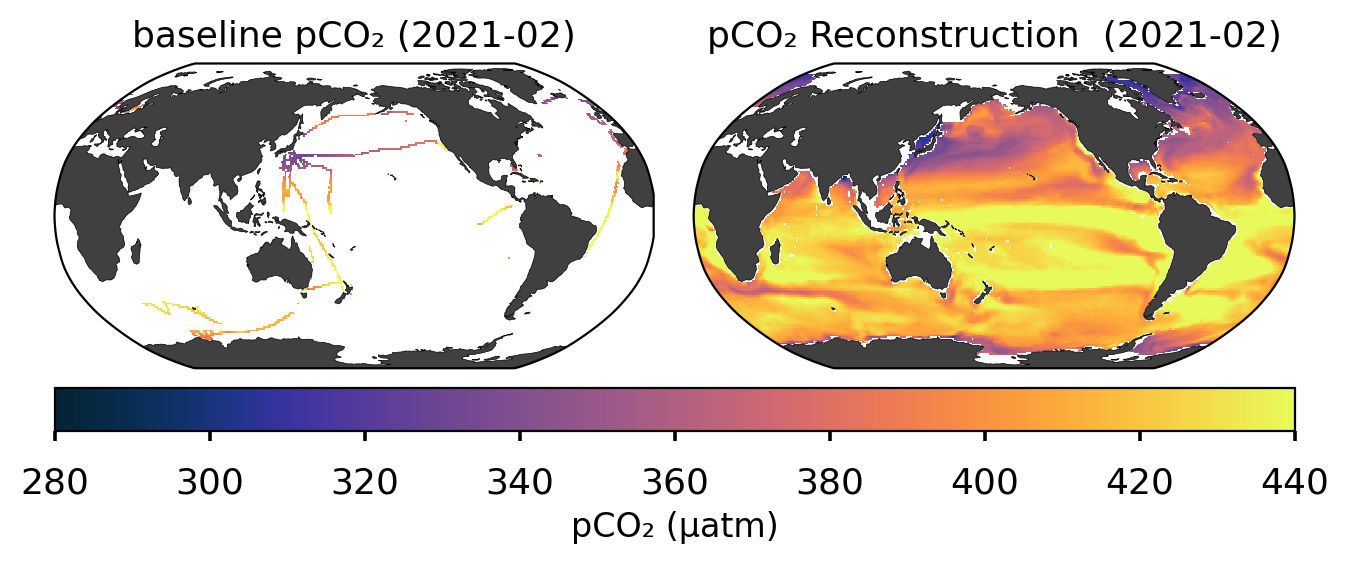

In [274]:
plot_reconstruction_vs_truth(
    mask_name="baseline",
    mask_data_dict=mask_data_dict,  # or any other mask from your mask_data_dict
    selected_mems_dict=selected_mems_dict,
    ensemble_dir=ensemble_dir,
    output_dir=output_dir,
    dates=dates,
    init_date=init_date,
    fin_date=fin_date,
    chosen_time="2021-02",
)


## 3.2 Comparison of Baseline vs models trained on more data

### 3.2.1 Analyze data added to locations historically sampled

### THINK MAKES SENSE TO SHOW 3 GRAPHS FOR EACH SAMPLE: 1.CHANGE IN AVG pCO2; 2. CHANGE IN STD; 3. CHANGE P.VAL

### THINK CAN DROP THE DENSIFY_MEAN_PATTERN GRAPHS

Member path: leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members/ACCESS-ESM1-5/member_r10i1p1f1/ACCESS-ESM1-5.r10i1p1f1.Omon.zarr
Recon path: gs://leap-persistent/azamkhan99/azamkhan99/pco2_residual/nmse/post02_xgb/reconstructions/densify_mean_pattern/ACCESS-ESM1-5/member_r10i1p1f1/recon_pCO2_ACCESS-ESM1-5_member_r10i1p1f1_mon_1x1_200401_202312.zarr


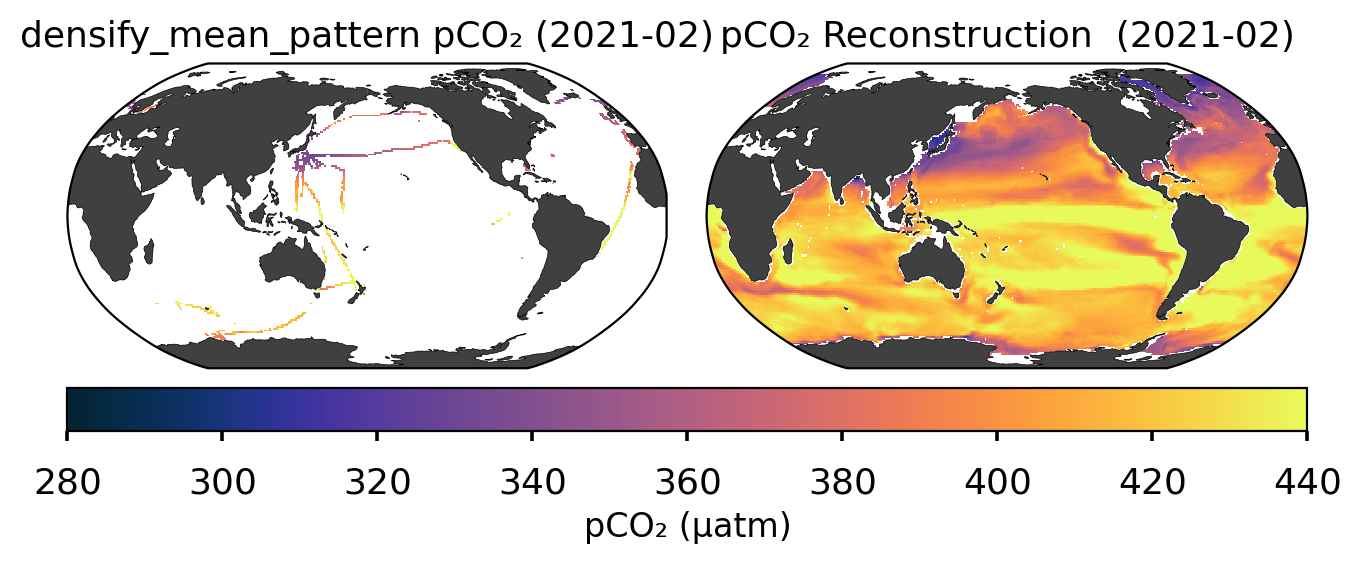

In [201]:
plot_reconstruction_vs_truth(
    mask_name="densify_mean_pattern",
    mask_data_dict=mask_data_dict,  # or any other mask from your mask_data_dict
    selected_mems_dict=selected_mems_dict,
    ensemble_dir=ensemble_dir,
    output_dir=output_dir,
    dates=dates,
    init_date=init_date,
    fin_date=fin_date,
    chosen_time="2021-02"
)


Member path: leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members/ACCESS-ESM1-5/member_r10i1p1f1/ACCESS-ESM1-5.r10i1p1f1.Omon.zarr
Recon path: gs://leap-persistent/azamkhan99/azamkhan99/pco2_residual/nmse/post02_xgb/reconstructions/densify_30p/ACCESS-ESM1-5/member_r10i1p1f1/recon_pCO2_ACCESS-ESM1-5_member_r10i1p1f1_mon_1x1_200401_202312.zarr


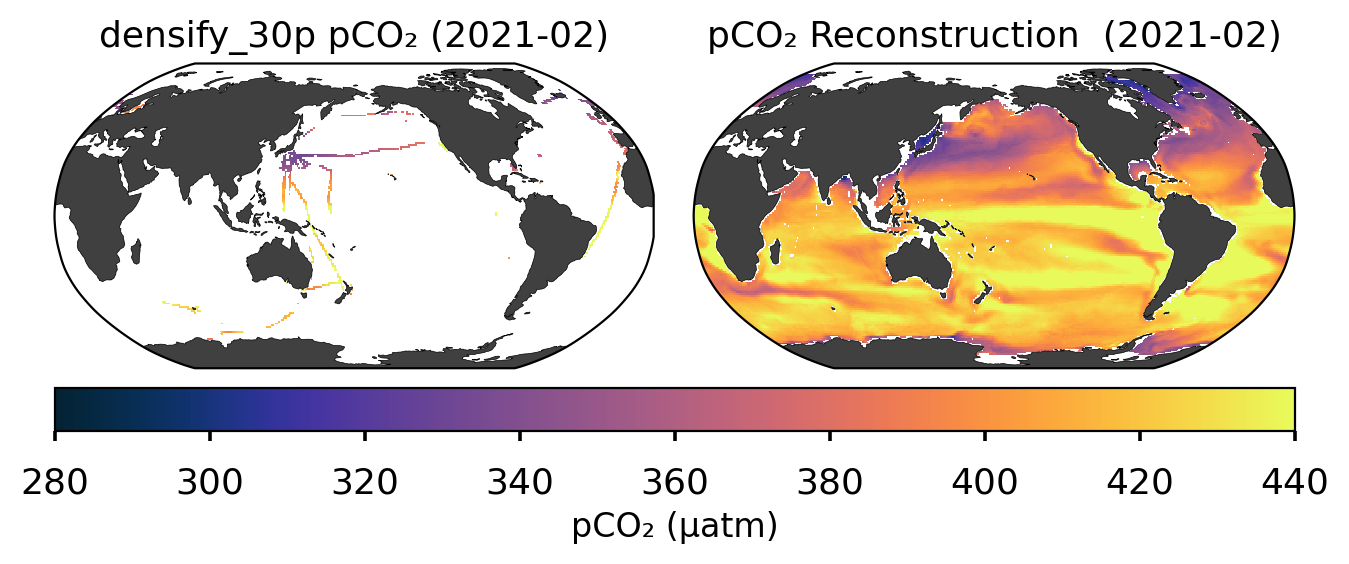

In [202]:
plot_reconstruction_vs_truth(
    mask_name="densify_30p",
    mask_data_dict=mask_data_dict,  # or any other mask from your mask_data_dict
    selected_mems_dict=selected_mems_dict,
    ensemble_dir=ensemble_dir,
    output_dir=output_dir,
    dates=dates,
    init_date=init_date,
    fin_date=fin_date,
    chosen_time="2021-02",
)


Member path: leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members/ACCESS-ESM1-5/member_r10i1p1f1/ACCESS-ESM1-5.r10i1p1f1.Omon.zarr
Recon path: gs://leap-persistent/azamkhan99/azamkhan99/pco2_residual/nmse/post02_xgb/reconstructions/densify_50p/ACCESS-ESM1-5/member_r10i1p1f1/recon_pCO2_ACCESS-ESM1-5_member_r10i1p1f1_mon_1x1_200401_202312.zarr


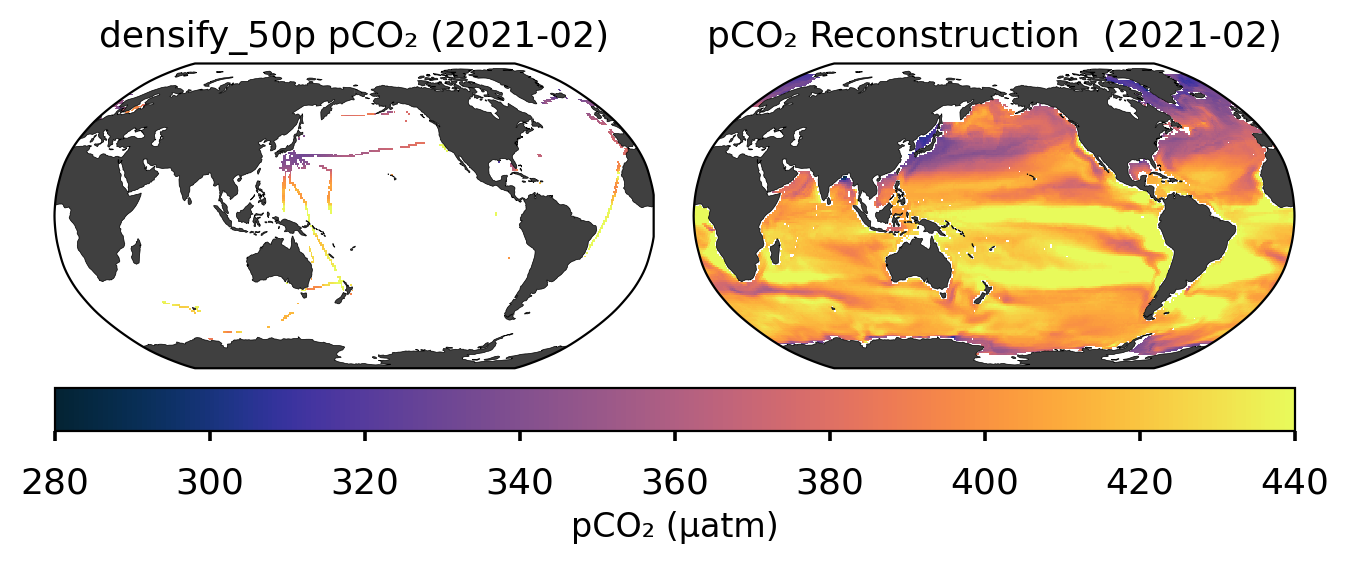

In [244]:
plot_reconstruction_vs_truth(
    mask_name="densify_50p",
    mask_data_dict=mask_data_dict,  # or any other mask from your mask_data_dict
    selected_mems_dict=selected_mems_dict,
    ensemble_dir=ensemble_dir,
    output_dir=output_dir,
    dates=dates,
    init_date=init_date,
    fin_date=fin_date,
    chosen_time="2021-02",
)


### 3.2.2 Analyze data added to new locations not historically sampled

### Match 3.2.1. SHOW 3 GRAPHS FOR EACH SAMPLE: 1.CHANGE IN AVG pCO2; 2. CHANGE IN STD; 3. CHANGE P.VAL

### DROP THE DENSIFY_MEAN_PATTERN GRAPHS

Member path: leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members/ACCESS-ESM1-5/member_r10i1p1f1/ACCESS-ESM1-5.r10i1p1f1.Omon.zarr
Recon path: gs://leap-persistent/azamkhan99/azamkhan99/pco2_residual/nmse/post02_xgb/reconstructions/expand_14p/ACCESS-ESM1-5/member_r10i1p1f1/recon_pCO2_ACCESS-ESM1-5_member_r10i1p1f1_mon_1x1_200401_202312.zarr


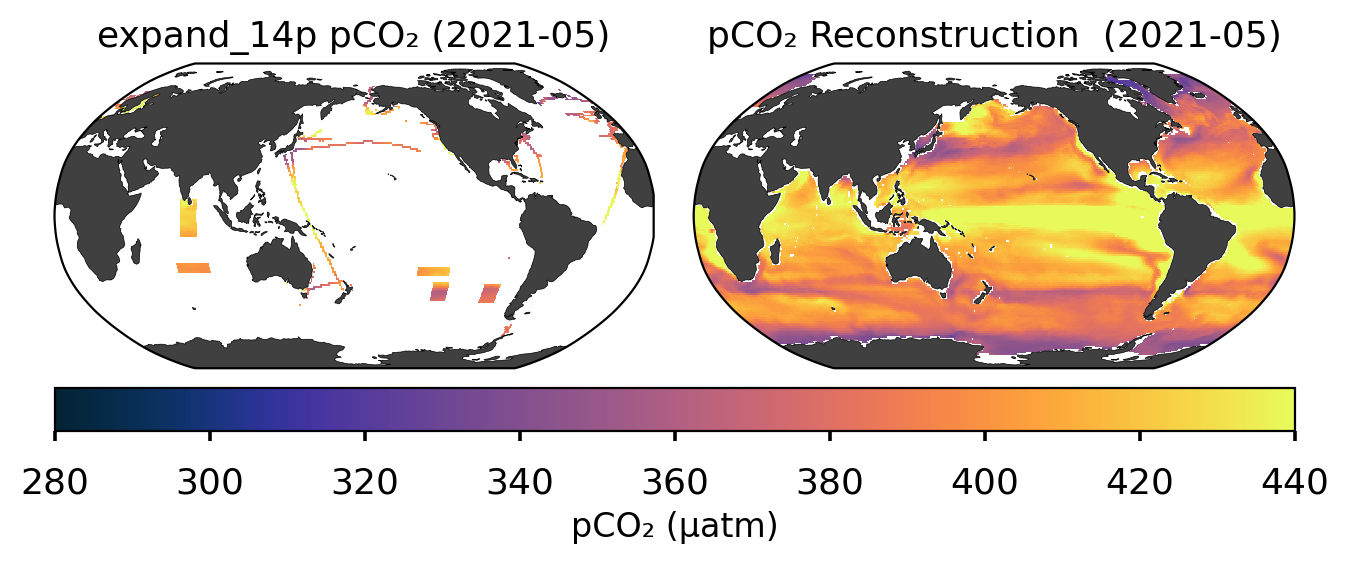

In [343]:
plot_reconstruction_vs_truth(
    mask_name="expand_14p",
    mask_data_dict=mask_data_dict,  # or any other mask from your mask_data_dict
    selected_mems_dict=selected_mems_dict,
    ensemble_dir=ensemble_dir,
    output_dir=output_dir,
    dates=dates,
    init_date=init_date,
    fin_date=fin_date,
    chosen_time="2021-05"
)


Member path: leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members/ACCESS-ESM1-5/member_r10i1p1f1/ACCESS-ESM1-5.r10i1p1f1.Omon.zarr
Recon path: gs://leap-persistent/azamkhan99/azamkhan99/pco2_residual/nmse/post02_xgb/reconstructions/expand_30p/ACCESS-ESM1-5/member_r10i1p1f1/recon_pCO2_ACCESS-ESM1-5_member_r10i1p1f1_mon_1x1_200401_202312.zarr


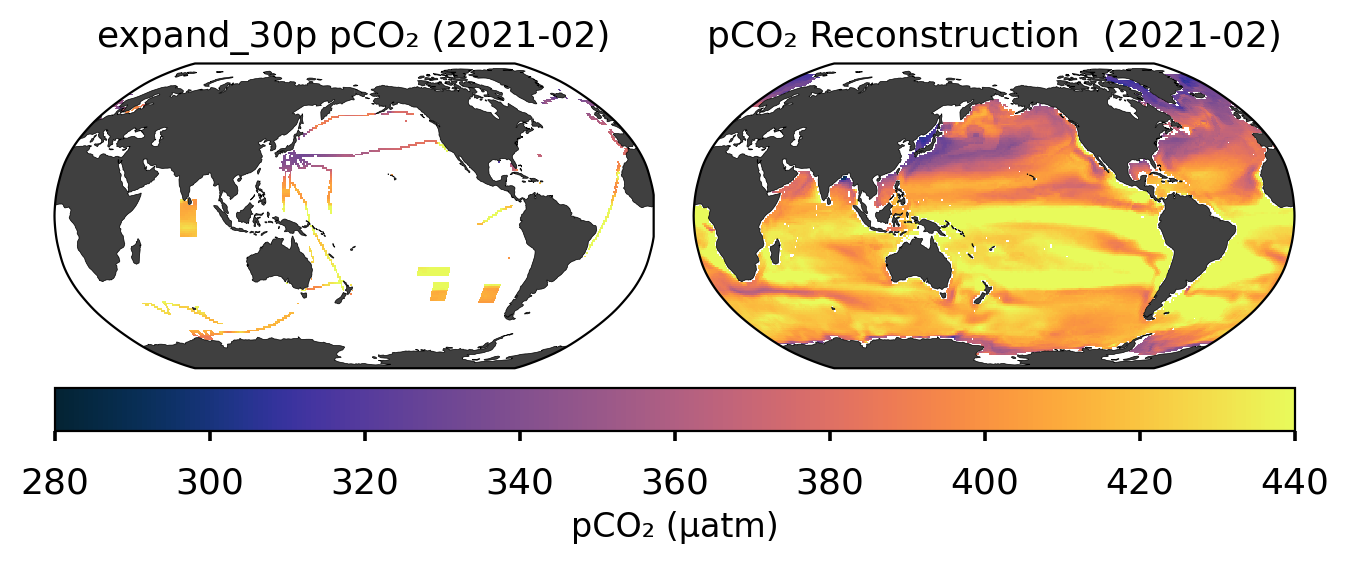

In [266]:
plot_reconstruction_vs_truth(
    mask_name="expand_30p",
    mask_data_dict=mask_data_dict,  # or any other mask from your mask_data_dict
    selected_mems_dict=selected_mems_dict,
    ensemble_dir=ensemble_dir,
    output_dir=output_dir,
    dates=dates,
    init_date=init_date,
    fin_date=fin_date,
    chosen_time="2021-02"
)


Member path: leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members/ACCESS-ESM1-5/member_r10i1p1f1/ACCESS-ESM1-5.r10i1p1f1.Omon.zarr
Recon path: gs://leap-persistent/azamkhan99/azamkhan99/pco2_residual/nmse/post02_xgb/reconstructions/expand_50p/ACCESS-ESM1-5/member_r10i1p1f1/recon_pCO2_ACCESS-ESM1-5_member_r10i1p1f1_mon_1x1_200401_202312.zarr


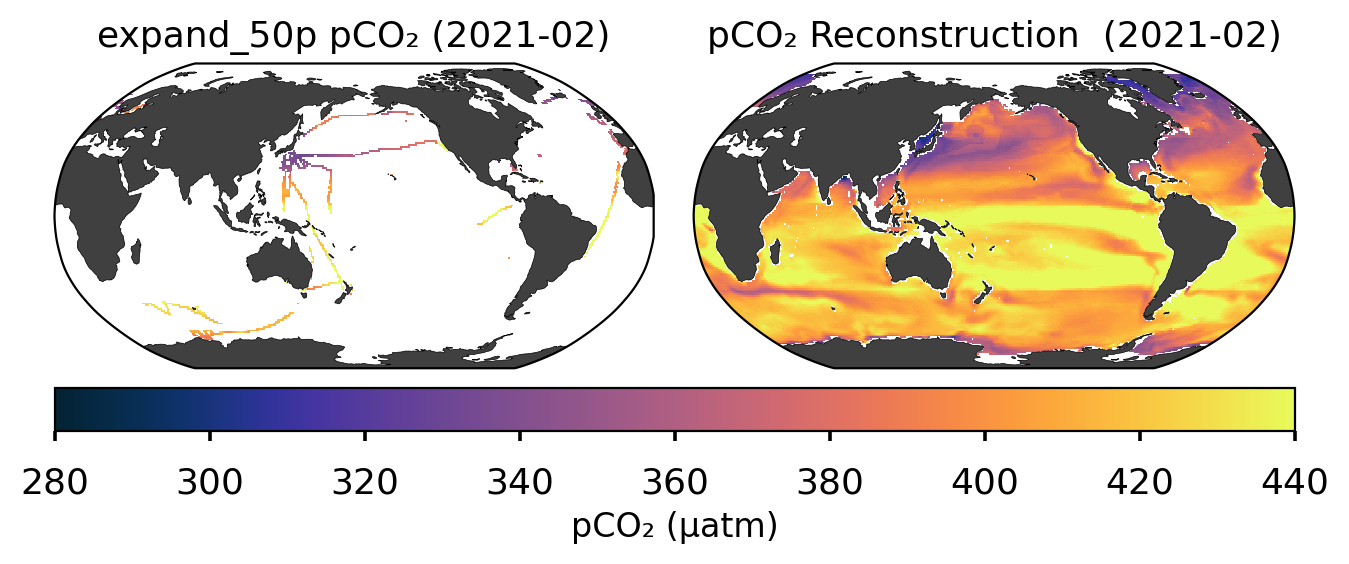

In [267]:
plot_reconstruction_vs_truth(
    mask_name="expand_50p",
    mask_data_dict=mask_data_dict,  # or any other mask from your mask_data_dict
    selected_mems_dict=selected_mems_dict,
    ensemble_dir=ensemble_dir,
    output_dir=output_dir,
    dates=dates,
    init_date=init_date,
    fin_date=fin_date,
    chosen_time="2021-02"
)

### SHOW STD IN ABOVE

In [355]:
def plot_reconstruction_std(
    mask_name,
    selected_mems_dict,
    output_dir,
    init_date,
    fin_date,
    chosen_time="2021-01",
    plot_style="seaborn-v0_8-talk",
    cmap=None,
    vrange=[280, 440],
):
    import matplotlib.pyplot as plt
    import cmocean.cm as cm
    import xarray as xr

    if cmap is None:
        cmap = cm.thermal

    # Select the first ensemble and member
    first_ens = list(selected_mems_dict.keys())[0]
    first_mem = selected_mems_dict[first_ens][0]

    # Load reconstructed pCO₂ data
    recon_output_dir = f"{output_dir}/reconstructions/{mask_name}"
    recon_dir = f"{recon_output_dir}/{first_ens}/{first_mem}"
    recon_path = f"{recon_dir}/recon_pCO2_{first_ens}_{first_mem}_mon_1x1_{init_date}_{fin_date}.zarr"
    print("Recon path:", recon_path)
    full = xr.open_zarr(recon_path, consolidated=True)["pCO2_recon_full_std"]

    # Extract specific month
    recon_data = full.sel(time=chosen_time)[0, ...]

    # Shift longitudes for global plotting
    recon_data = recon_data.roll(xlon=len(recon_data.xlon) // 2, roll_coords=True)

    # Start plotting
    with plt.style.context(plot_style):
        fig = plt.figure(figsize=(8, 3), dpi=200)
        worldmap = SpatialMap2(
            fig=fig,
            region="world",
            cbar_mode="single",
            colorbar=True,
            cbar_location="bottom",
            nrows_ncols=[1, 1],
        )

        sub1 = worldmap.add_plot(
            lon=recon_data["xlon"],
            lat=recon_data["ylat"],
            data=recon_data,
            vrange=vrange,
            cmap=cmap,
            ax=0,
        )

        worldmap.set_title(
            f"pCO₂ STD Reconstruction ({chosen_time})", ax=0, fontsize=13
        )

        colorbar = worldmap.add_colorbar(sub1, ax=0)
        worldmap.set_cbar_xlabel(colorbar, "pCO₂ (µatm)", fontsize=12)

        plt.show()


Recon path: gs://leap-persistent/azamkhan99/azamkhan99/pco2_residual/nmse/post02_xgb/reconstructions/densify_mean_pattern/ACCESS-ESM1-5/member_r10i1p1f1/recon_pCO2_ACCESS-ESM1-5_member_r10i1p1f1_mon_1x1_200401_202312.zarr


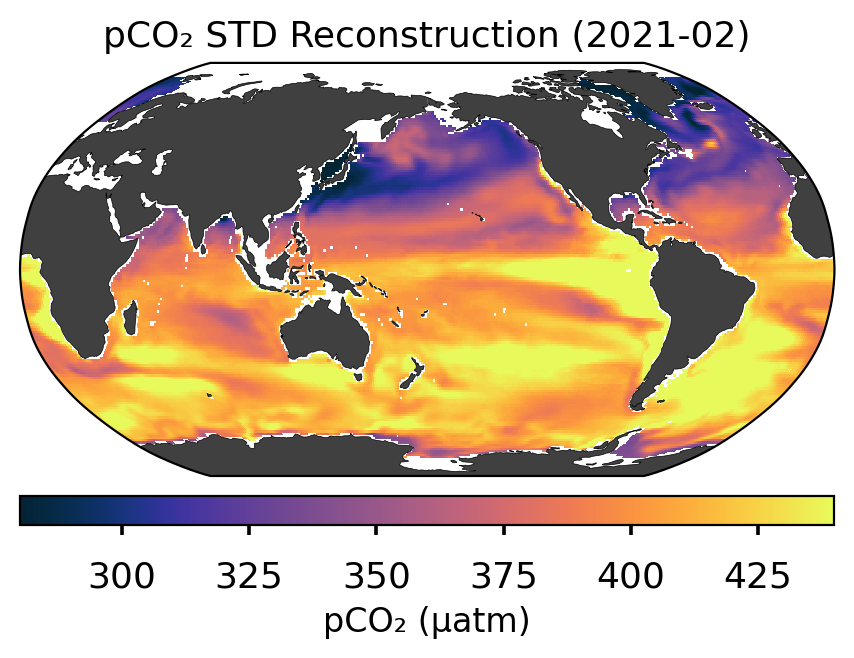

In [360]:
plot_reconstruction_std(
    mask_name="densify_mean_pattern",
    selected_mems_dict=selected_mems_dict,
    output_dir=output_dir,
    init_date=init_date,
    fin_date=fin_date,
    chosen_time="2021-02",
)

#### side by side comparison to see effect of different sampling strategies

In [368]:
import cmocean.cm as cm
def plot_reconstruction_std_side_by_side(
    mask_name_1,
    mask_name_2,
    selected_mems_dict,
    output_dir,
    init_date,
    fin_date,
    chosen_time="2021-01",
    plot_style="seaborn-v0_8-talk",
    cmap=None,
     vrange=[280, 440],
):
    """
    Plot the STD of reconstructed pCO₂ side-by-side for two masking strategies.
    """
    if cmap is None:
        cmap = cm.thermal

    # Select the first ensemble and member
    first_ens = list(selected_mems_dict.keys())[0]
    first_mem = selected_mems_dict[first_ens][0]

    # Load reconstructed pCO₂ STD for both masks
    recon_path_1 = f"{output_dir}/reconstructions/{mask_name_1}/{first_ens}/{first_mem}/recon_pCO2_{first_ens}_{first_mem}_mon_1x1_{init_date}_{fin_date}.zarr"
    recon_path_2 = f"{output_dir}/reconstructions/{mask_name_2}/{first_ens}/{first_mem}/recon_pCO2_{first_ens}_{first_mem}_mon_1x1_{init_date}_{fin_date}.zarr"

    full_std_1 = xr.open_zarr(recon_path_1, consolidated=True)["pCO2_recon_full_std"]
    full_std_2 = xr.open_zarr(recon_path_2, consolidated=True)["pCO2_recon_full_std"]

    # Extract specific month
    std_1 = full_std_1.sel(time=chosen_time)[0, ...]
    std_2 = full_std_2.sel(time=chosen_time)[0, ...]

    # Align longitudes
    std_1 = std_1.roll(xlon=len(std_1.xlon) // 2, roll_coords=True)
    std_2 = std_2.roll(xlon=len(std_2.xlon) // 2, roll_coords=True)

    # Start plotting
    with plt.style.context(plot_style):
        fig = plt.figure(figsize=(12, 4), dpi=200)
        worldmap = SpatialMap2(
            fig=fig,
            region="world",
            cbar_mode="single",
            colorbar=True,
            cbar_location="bottom",
            nrows_ncols=[1, 2],
        )

        sub0 = worldmap.add_plot(
            lon=std_1["xlon"],
            lat=std_1["ylat"],
            data=std_1,
            vrange=vrange,
            cmap=cmap,
            ax=0,
        )

        sub1 = worldmap.add_plot(
            lon=std_2["xlon"],
            lat=std_2["ylat"],
            data=std_2,
            vrange=vrange,
            cmap=cmap,
            ax=1,
        )

        worldmap.set_title(f"STD {mask_name_1} ({chosen_time})", ax=0, fontsize=13)
        worldmap.set_title(f"STD {mask_name_2} ({chosen_time})", ax=1, fontsize=13)

        colorbar = worldmap.add_colorbar(sub0, ax=0)
        worldmap.set_cbar_xlabel(colorbar, "STD pCO₂ (µatm)", fontsize=12)

        plt.show()


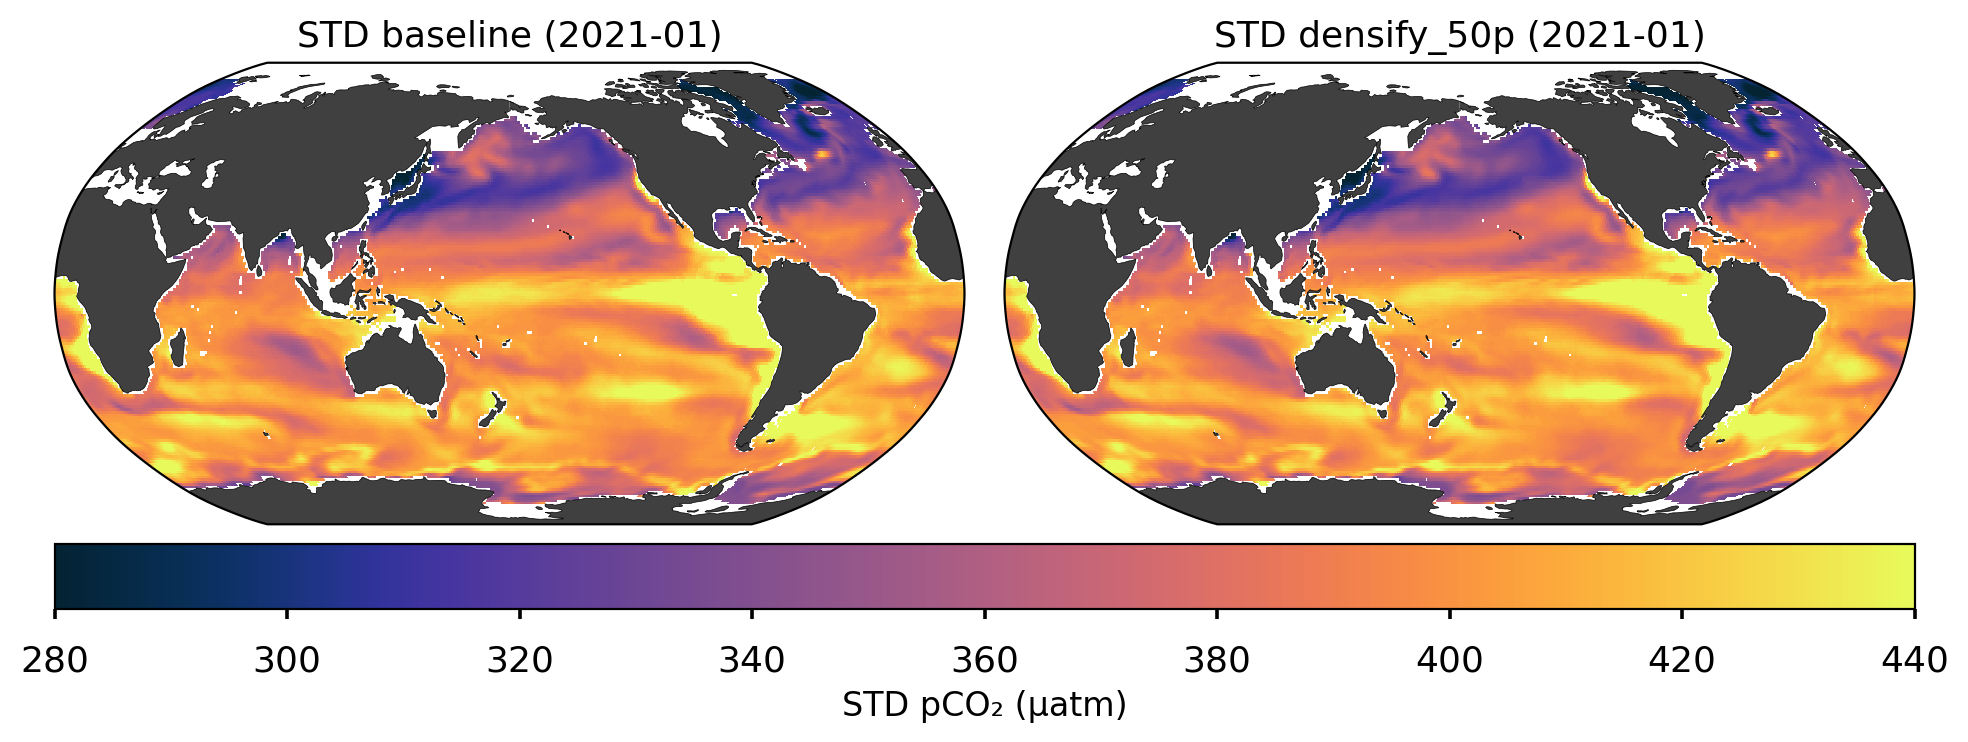

In [370]:
plot_reconstruction_std_side_by_side(
    mask_name_1="baseline",
    mask_name_2="densify_50p",
    selected_mems_dict=selected_mems_dict,
    output_dir=output_dir,
    init_date=init_date,
    fin_date=fin_date,
    chosen_time="2021-01",
)


#### SHOW DIFFERENCE ABOVE (plotting the difference in prediction std between two masks)

In [380]:
import cmocean.cm as cm
def plot_reconstruction_std_difference(
    mask_name_1,
    mask_name_2,
    selected_mems_dict,
    output_dir,
    init_date,
    fin_date,
    chosen_time="2021-01",
    plot_style="seaborn-v0_8-talk",
    cmap_diff=cm.thermal,
    diff_vrange=[-20, 20],
):
    
    # cmap_diff = cm.get_cmap(cmap_diff)
    """
    Plot the difference between STD maps of two reconstructions from different masking strategies.
    """
    

    # Select the first ensemble and member
    first_ens = list(selected_mems_dict.keys())[0]
    first_mem = selected_mems_dict[first_ens][0]

    # Load reconstructed pCO₂ std for both masks
    recon_path_1 = f"{output_dir}/reconstructions/{mask_name_1}/{first_ens}/{first_mem}/recon_pCO2_{first_ens}_{first_mem}_mon_1x1_{init_date}_{fin_date}.zarr"
    recon_path_2 = f"{output_dir}/reconstructions/{mask_name_2}/{first_ens}/{first_mem}/recon_pCO2_{first_ens}_{first_mem}_mon_1x1_{init_date}_{fin_date}.zarr"

    full_std_1 = xr.open_zarr(recon_path_1, consolidated=True)["pCO2_recon_full_std"]
    full_std_2 = xr.open_zarr(recon_path_2, consolidated=True)["pCO2_recon_full_std"]

    # Extract specific month
    std_1 = full_std_1.sel(time=chosen_time)[0, ...]
    std_2 = full_std_2.sel(time=chosen_time)[0, ...]

    # Align longitudes
    std_1 = std_1.roll(xlon=len(std_1.xlon) // 2, roll_coords=True)
    std_2 = std_2.roll(xlon=len(std_2.xlon) // 2, roll_coords=True)

    # Compute the difference (Mask2 - Mask1)
    std_diff = std_2 - std_1

    # Start plotting
    with plt.style.context(plot_style):
        fig = plt.figure(figsize=(8, 3), dpi=200)
        worldmap = SpatialMap2(
            fig=fig,
            region="world",
            cbar_mode="single",
            colorbar=True,
            cbar_location="bottom",
            nrows_ncols=[1, 1],
        )

        sub0 = worldmap.add_plot(
            lon=std_diff["xlon"],
            lat=std_diff["ylat"],
            data=std_diff,
            vrange=diff_vrange,
            cmap=cmap_diff,
            ax=0,
        )

        worldmap.set_title(
            f"STD Difference ({mask_name_2} - {mask_name_1}) ({chosen_time})",
            ax=0,
            fontsize=13,
        )

        colorbar = worldmap.add_colorbar(sub0, ax=0)
        worldmap.set_cbar_xlabel(colorbar, "Δ STD pCO₂ (µatm)", fontsize=12)

        plt.show()


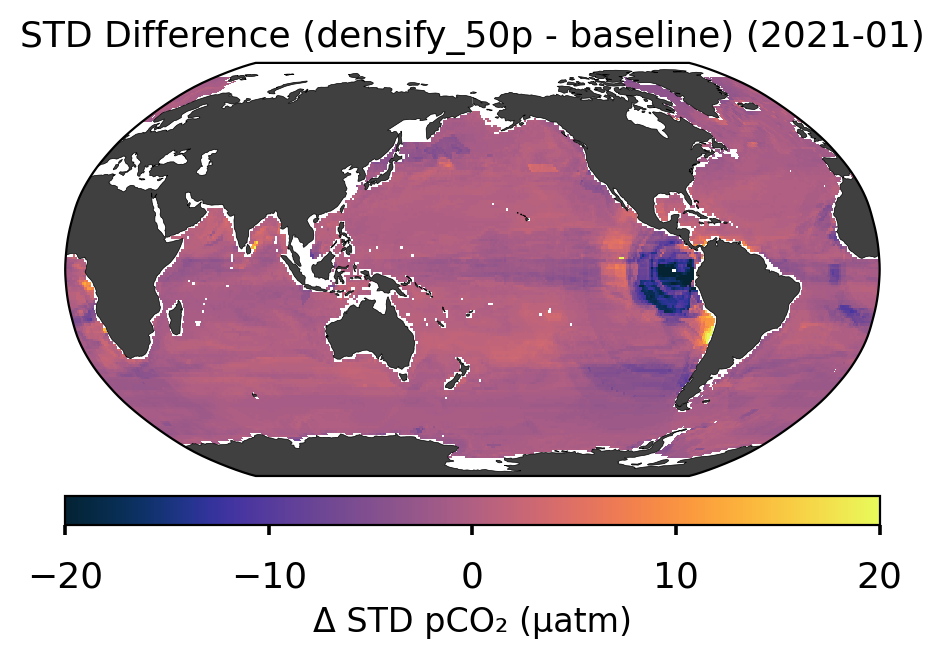

In [384]:
plot_reconstruction_std_difference(
    mask_name_1="baseline",
    mask_name_2="densify_50p",
    selected_mems_dict=selected_mems_dict,
    output_dir=output_dir,
    init_date=init_date,
    fin_date=fin_date,
    chosen_time="2021-01",
)


### SHOW IN ABOVE (Plotting the mean of the Reconstruction from NGBoost)

In [ ]:
def plot_reconstruction_mean(
    mask_name,
    selected_mems_dict,
    output_dir,
    init_date,
    fin_date,
    chosen_time="2021-01",
    plot_style="seaborn-v0_8-talk",
    cmap=None,
    vrange=[280, 440],
):
    import matplotlib.pyplot as plt
    import cmocean.cm as cm
    import xarray as xr

    if cmap is None:
        cmap = cm.thermal

    # Select the first ensemble and member
    first_ens = list(selected_mems_dict.keys())[0]
    first_mem = selected_mems_dict[first_ens][0]

    # Load reconstructed pCO₂ data
    recon_output_dir = f"{output_dir}/reconstructions/{mask_name}"
    recon_dir = f"{recon_output_dir}/{first_ens}/{first_mem}"
    recon_path = f"{recon_dir}/recon_pCO2_{first_ens}_{first_mem}_mon_1x1_{init_date}_{fin_date}.zarr"
    print("Recon path:", recon_path)
    full = xr.open_zarr(recon_path, consolidated=True)["pCO2_recon_full_mean"]

    # Extract specific month
    recon_data = full.sel(time=chosen_time)[0, ...]

    # Shift longitudes for global plotting
    recon_data = recon_data.roll(xlon=len(recon_data.xlon) // 2, roll_coords=True)

    # Start plotting
    with plt.style.context(plot_style):
        fig = plt.figure(figsize=(8, 3), dpi=200)
        worldmap = SpatialMap2(
            fig=fig,
            region="world",
            cbar_mode="single",
            colorbar=True,
            cbar_location="bottom",
            nrows_ncols=[1, 1],
        )

        sub1 = worldmap.add_plot(
            lon=recon_data["xlon"],
            lat=recon_data["ylat"],
            data=recon_data,
            vrange=vrange,
            cmap=cmap,
            ax=0,
        )

        worldmap.set_title(
            f"pCO₂ STD Reconstruction ({chosen_time})", ax=0, fontsize=13
        )

        colorbar = worldmap.add_colorbar(sub1, ax=0)
        worldmap.set_cbar_xlabel(colorbar, "pCO₂ (µatm)", fontsize=12)

        plt.show()


### INCLUDE IN ABOVE (Diff plots)

In [336]:
# !!!!!! RUN IF YOU DONT WANT TO RUN THE CELLS ABOVE TO GENERATE DIFF PLOTS !!!!!!!
run_this_cell = 0 # 0 will turn off, 1 will turn on
if run_this_cell == 1:

    mask_data_dict = {
        "baseline": socat_mask_data,
        "densify_mean_pattern": socat_mean_glob,
        "densify_30p": socat_30p_glob,
        "densify_50p": socat_50p_glob,
        "expand_14p": addmeanp_socat,
        "expand_30p": add30p_socat,
        "expand_50p": add50p_socat,
    }

    selected_mems_dict = {
        "ACCESS-ESM1-5": ["member_r10i1p1f1", "member_r5i1p1f1", "member_r2i1p1f1"],
    }
    ensemble_dir = "gs://leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members"  # path to regridded data
    output_dir = f"gs://leap-persistent/azamkhan99/azamkhan99/pco2_residual/nmse/post02_xgb"  # where to save machine learning results

    ### Setting the date range to unify the date type ###

    # Define date range
    date_range_start = "2004-01-01T00:00:00.000000000"
    date_range_end = "2023-12-31T00:00:00.000000000"

    # create date vector, adds 14 days to start & end
    dates = pd.date_range(start=date_range_start, end=date_range_end, freq="MS")


    init_date = str(dates[0].year) + format(dates[0].month, "02d")
    fin_date = str(dates[-1].year) + format(dates[-1].month, "02d")

### SHOW IN ABOVE (Reconstruction difference)

In [277]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def plot_masking_strategy_difference(
    mask_name_1,
    mask_name_2,
    mask_data_dict,
    selected_mems_dict,
    ensemble_dir,
    output_dir,
    dates,
    init_date,
    fin_date,
    plot_style="seaborn-v0_8-talk",
    cmap_diff="RdBu_r",  # Colormap as a string
    diff_vrange=[-30, 30],
    chosen_time="2021-01",
):
    """
    Plot the difference between reconstructions from two different masking strategies.
    """
    import numpy as np
    import xarray as xr

    # Select the first ensemble and member
    first_ens = list(selected_mems_dict.keys())[0]
    first_mem = selected_mems_dict[first_ens][0]

    # Load reconstructed pCO₂ for both masks
    recon_path_1 = f"{output_dir}/reconstructions/{mask_name_1}/{first_ens}/{first_mem}/recon_pCO2_{first_ens}_{first_mem}_mon_1x1_{init_date}_{fin_date}.zarr"
    recon_path_2 = f"{output_dir}/reconstructions/{mask_name_2}/{first_ens}/{first_mem}/recon_pCO2_{first_ens}_{first_mem}_mon_1x1_{init_date}_{fin_date}.zarr"

    recon_1 = xr.open_zarr(recon_path_1, consolidated=True)["pCO2_recon_full"].sel(
        time=chosen_time
    )[0, ...]
    recon_2 = xr.open_zarr(recon_path_2, consolidated=True)["pCO2_recon_full"].sel(
        time=chosen_time
    )[0, ...]

    # Align longitudes
    recon_1 = recon_1.roll(xlon=len(recon_1.xlon) // 2, roll_coords=True)
    recon_2 = recon_2.roll(xlon=len(recon_2.xlon) // 2, roll_coords=True)

    # Calculate the difference
    diff = recon_2 - recon_1

    # Convert colormap string to colormap object
    cmap_diff = cm.get_cmap(cmap_diff)

    # Start plotting
    with plt.style.context(plot_style):
        fig = plt.figure(figsize=(6, 3), dpi=200)
        worldmap = SpatialMap2(
            fig=fig,
            region="world",
            cbar_mode="single",
            colorbar=True,
            cbar_location="bottom",
            nrows_ncols=[1, 1],
        )

        sub0 = worldmap.add_plot(
            lon=recon_1["xlon"],
            lat=recon_1["ylat"],
            data=diff,
            vrange=diff_vrange,
            cmap=cmap_diff,  # Pass the colormap object
            ax=0,
        )

        worldmap.set_title(
            f"Reconstruction Difference\n({mask_name_2} - {mask_name_1}) ({chosen_time})",
            ax=0,
            fontsize=13,
        )
        colorbar = worldmap.add_colorbar(sub0, ax=0)
        worldmap.set_cbar_xlabel(colorbar, "Δ pCO₂ (µatm)", fontsize=12)

        plt.show()


/tmp/ipykernel_64/2915528953.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_diff = cm.get_cmap(cmap_diff)


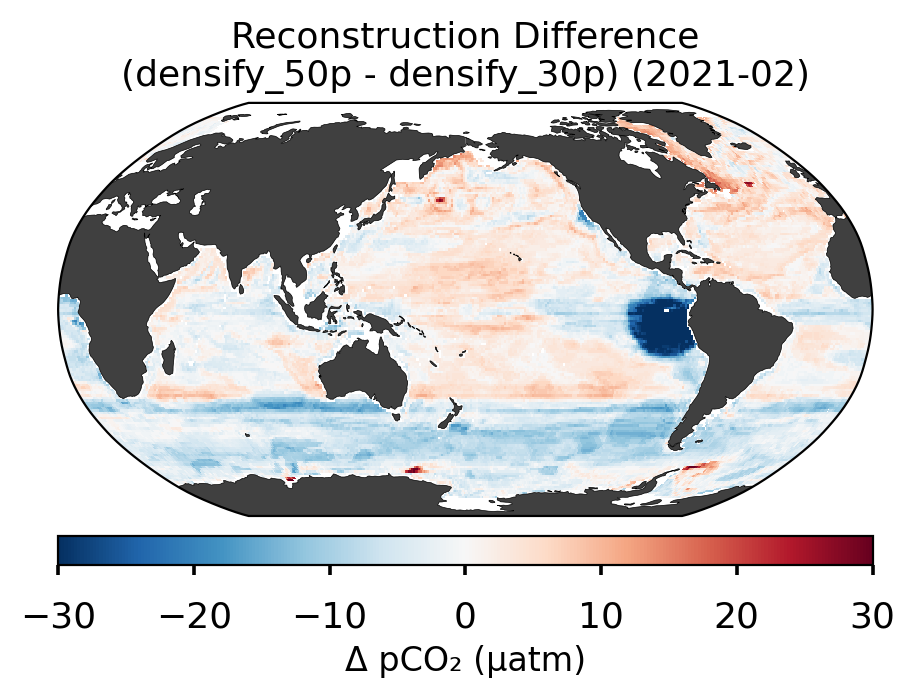

In [334]:
plot_masking_strategy_difference(
    mask_name_1="densify_30p",
    mask_name_2="densify_50p",
    mask_data_dict=mask_data_dict,
    selected_mems_dict=selected_mems_dict,
    ensemble_dir=ensemble_dir,
    output_dir=output_dir,
    dates=dates,
    init_date=init_date,
    fin_date=fin_date,
    chosen_time="2021-02",
)


/tmp/ipykernel_64/2915528953.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_diff = cm.get_cmap(cmap_diff)


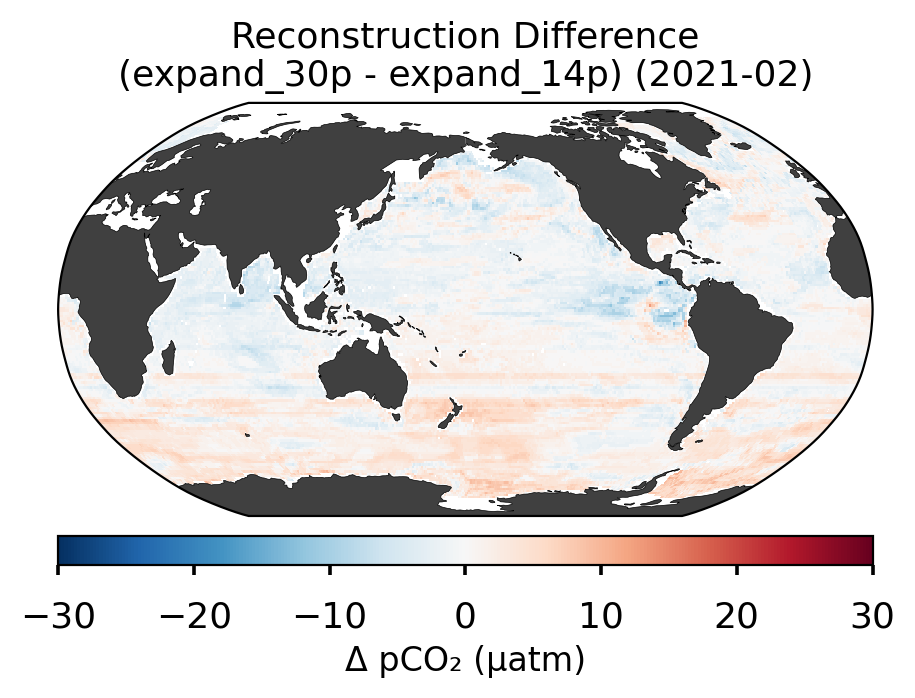

In [335]:
plot_masking_strategy_difference(
    mask_name_1="expand_14p",
    mask_name_2="expand_30p",
    mask_data_dict=mask_data_dict,
    selected_mems_dict=selected_mems_dict,
    ensemble_dir=ensemble_dir,
    output_dir=output_dir,
    dates=dates,
    init_date=init_date,
    fin_date=fin_date,
    chosen_time="2021-02",
)


### already have mask differences so dropped

### MOVE TO ABOVE BUT AVG (Comparing baseline to Augmented Masks)

In [312]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

def plot_monthly_comparison_panel(
    mask_name_1,
    mask_name_2,
    mask_data_dict,
    selected_mems_dict,
    ensemble_dir,
    output_dir,
    dates,
    init_date,
    fin_date,
    chosen_time="2021-01",
    mask_vrange=[0, 1],
    diff_vrange=[-30, 30],
    cmap_mask="Blues",
    cmap_diff="RdBu_r",
    plot_style="seaborn-v0_8-talk",
):
    
    cmap_mask = cm.get_cmap(cmap_mask)
    cmap_diff = cm.get_cmap(cmap_diff)

    # Select first ensemble member
    first_ens = list(selected_mems_dict.keys())[0]
    first_mem = selected_mems_dict[first_ens][0]

    # Load masks
    mask1 = mask_data_dict[mask_name_1].sel(time=chosen_time)["socat_mask"].squeeze()
    mask2 = mask_data_dict[mask_name_2].sel(time=chosen_time)["socat_mask"].squeeze()

    # Load reconstructions
    recon_path_1 = f"{output_dir}/reconstructions/{mask_name_1}/{first_ens}/{first_mem}/recon_pCO2_{first_ens}_{first_mem}_mon_1x1_{init_date}_{fin_date}.zarr"
    recon_path_2 = f"{output_dir}/reconstructions/{mask_name_2}/{first_ens}/{first_mem}/recon_pCO2_{first_ens}_{first_mem}_mon_1x1_{init_date}_{fin_date}.zarr"

    recon1 = xr.open_zarr(recon_path_1, consolidated=True)["pCO2_recon_full"].sel(
        time=chosen_time
    )[0, ...]
    recon2 = xr.open_zarr(recon_path_2, consolidated=True)["pCO2_recon_full"].sel(
        time=chosen_time
    )[0, ...]

    # Align longitude (roll at 180°)
    mask1 = mask1.roll(xlon=len(mask1.xlon) // 2, roll_coords=True)
    mask2 = mask2.roll(xlon=len(mask2.xlon) // 2, roll_coords=True)
    recon1 = recon1.roll(xlon=len(recon1.xlon) // 2, roll_coords=True)
    recon2 = recon2.roll(xlon=len(recon2.xlon) // 2, roll_coords=True)

    # Difference in reconstructions
    diff = recon2 - recon1

    # Start plotting
    with plt.style.context(plot_style):
        fig = plt.figure(figsize=(15, 4), dpi=200)
        worldmap = SpatialMap2(
            fig=fig,
            region="world",
            cbar_mode="each",
            colorbar=True,
            cbar_location="bottom",
            nrows_ncols=[1, 3],
        )

        # Left: sampling mask 1
        sub0 = worldmap.add_plot(
            lon=mask1["xlon"],
            lat=mask1["ylat"],
            data=mask1,
            vrange=mask_vrange,
            cmap=cmap_mask,
            ax=0,
        )
        worldmap.set_title(f"Mask: {mask_name_1}", ax=0, fontsize=13)

        # Center: sampling mask 2
        sub1 = worldmap.add_plot(
            lon=mask2["xlon"],
            lat=mask2["ylat"],
            data=mask2,
            vrange=mask_vrange,
            cmap=cmap_mask,
            ax=1,
        )
        worldmap.set_title(f"Mask: {mask_name_2}", ax=1, fontsize=13)

        # Right: difference in reconstruction
        sub2 = worldmap.add_plot(
            lon=diff["xlon"],
            lat=diff["ylat"],
            data=diff,
            vrange=diff_vrange,
            cmap=cmap_diff,
            ax=2,
        )
        worldmap.set_title(
            f"Reconstruction Difference\n({mask_name_2} - {mask_name_1})",
            ax=2,
            fontsize=13,
        )

        # Colorbars
        cbar0 = worldmap.add_colorbar(sub0, ax=0)
        cbar1 = worldmap.add_colorbar(sub1, ax=1)
        cbar2 = worldmap.add_colorbar(sub2, ax=2)

        worldmap.set_cbar_xlabel(cbar0, "Sampling Presence", fontsize=11)
        worldmap.set_cbar_xlabel(cbar1, "Sampling Presence", fontsize=11)
        worldmap.set_cbar_xlabel(cbar2, "Δ pCO₂ (µatm)", fontsize=11)


        plt.tight_layout()
        plt.show()


/tmp/ipykernel_64/991563459.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_mask = cm.get_cmap(cmap_mask)
/tmp/ipykernel_64/991563459.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_diff = cm.get_cmap(cmap_diff)


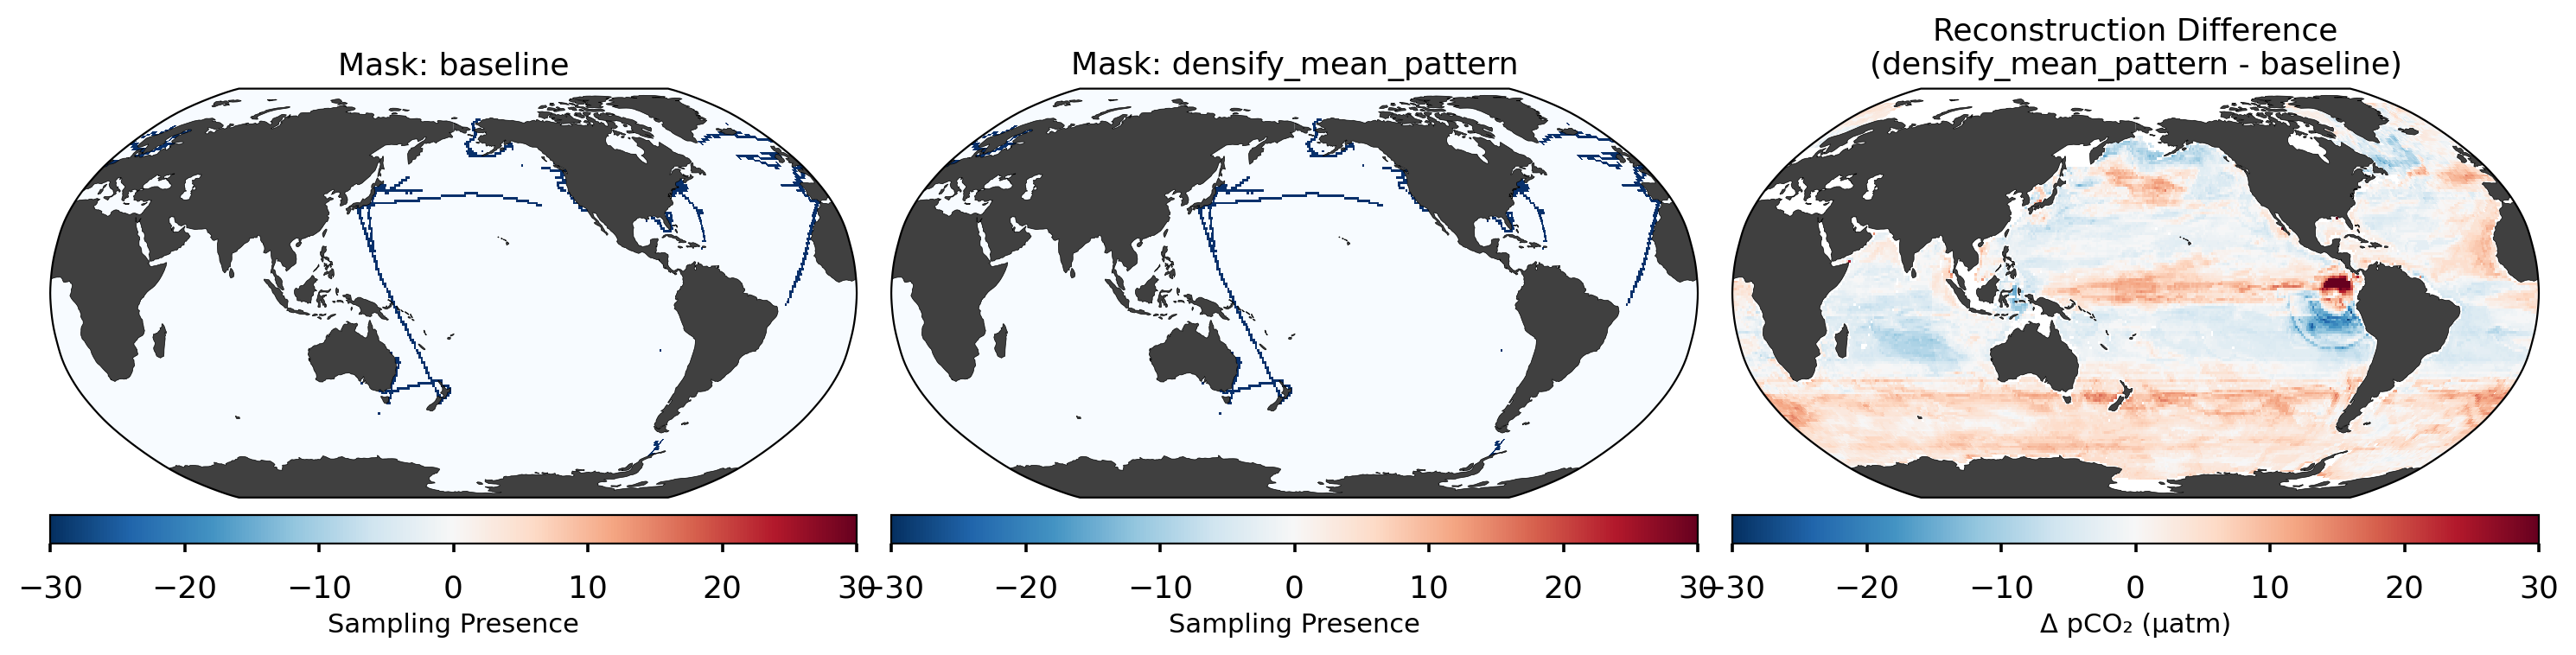

/tmp/ipykernel_64/991563459.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_mask = cm.get_cmap(cmap_mask)
/tmp/ipykernel_64/991563459.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_diff = cm.get_cmap(cmap_diff)


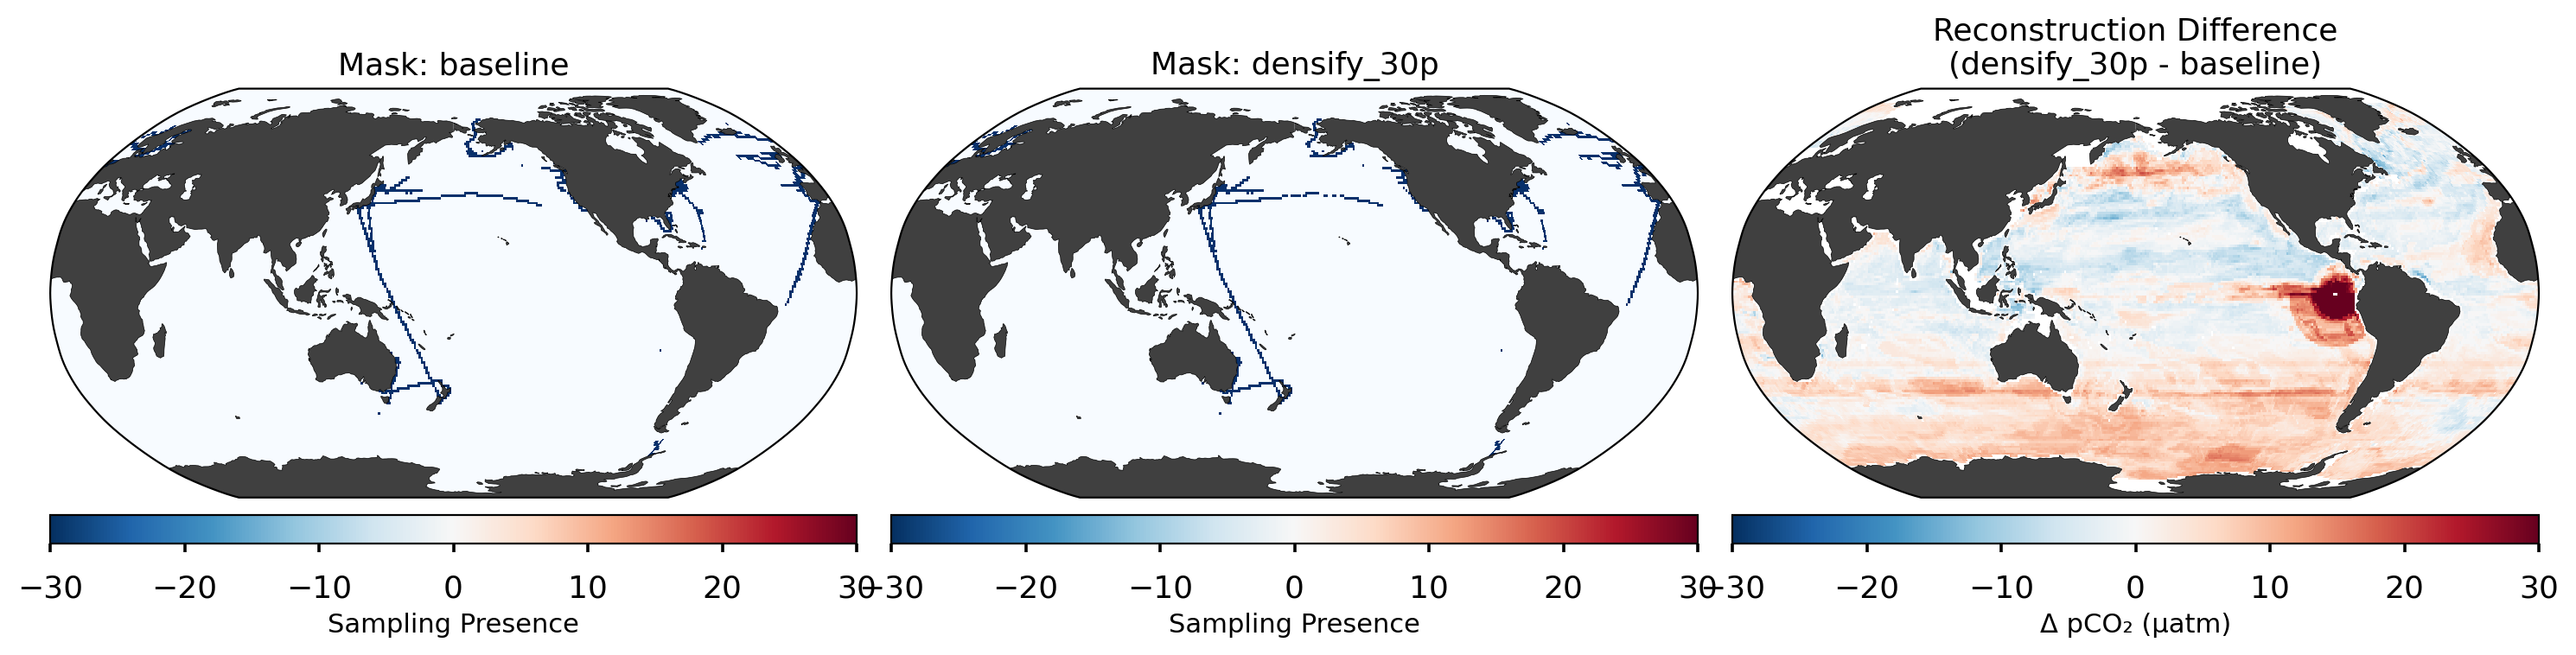

/tmp/ipykernel_64/991563459.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_mask = cm.get_cmap(cmap_mask)
/tmp/ipykernel_64/991563459.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_diff = cm.get_cmap(cmap_diff)


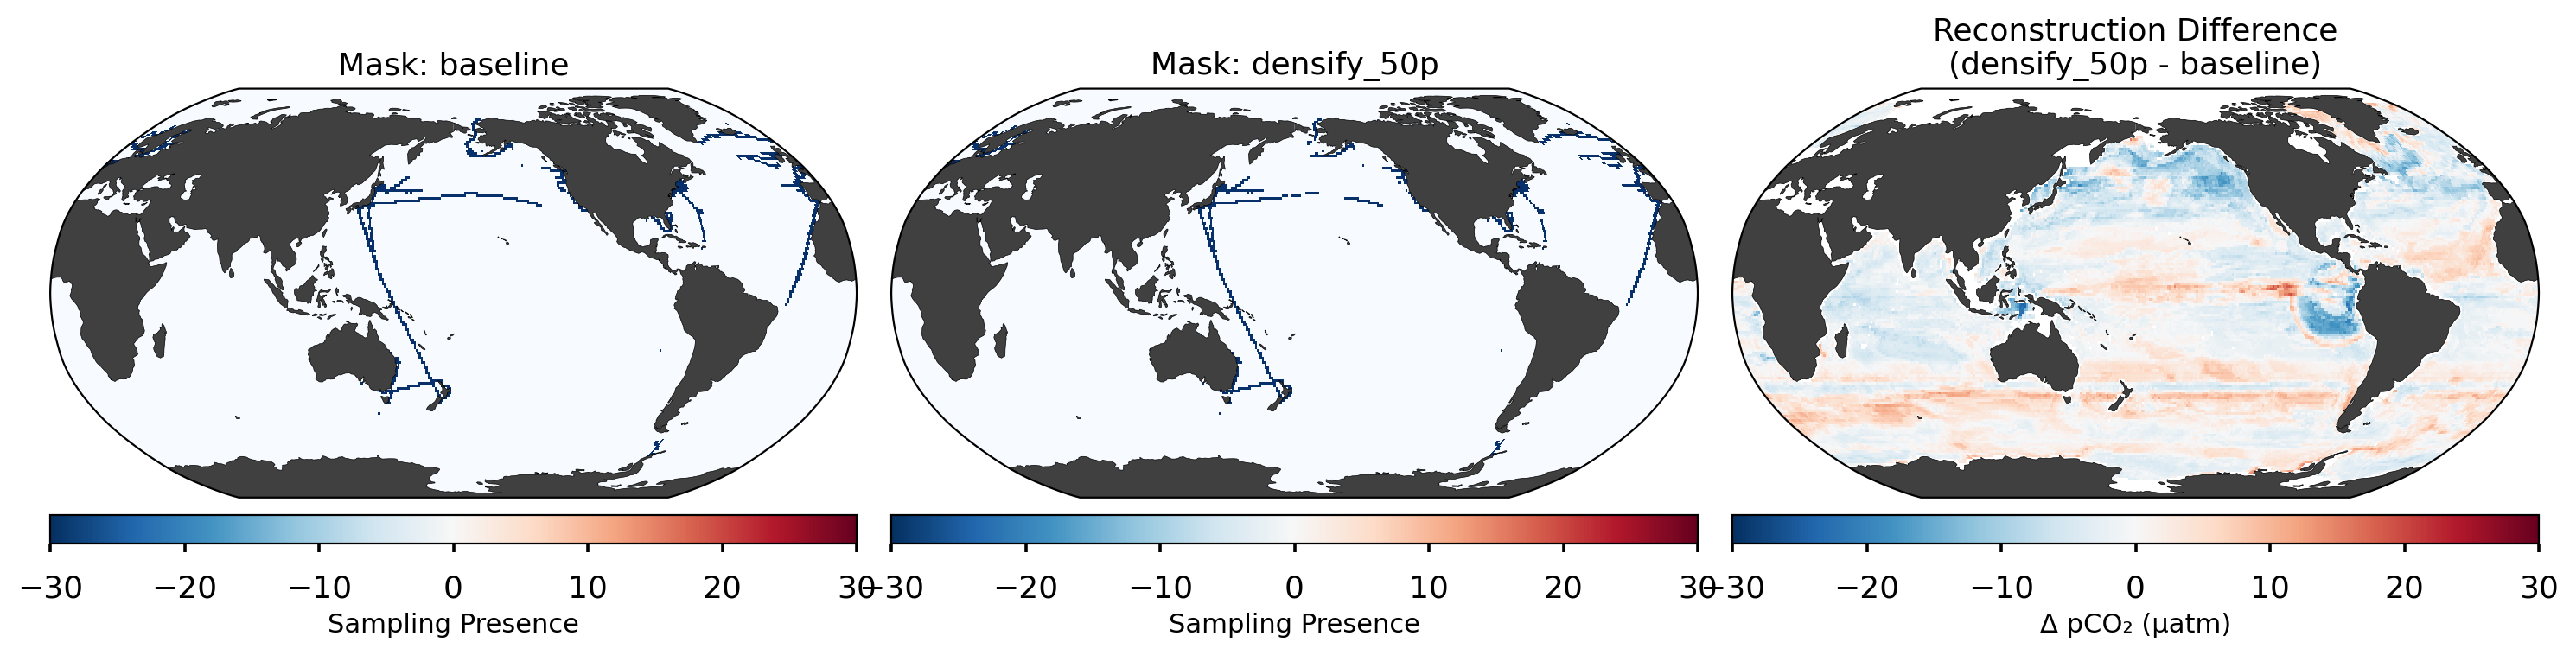

/tmp/ipykernel_64/991563459.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_mask = cm.get_cmap(cmap_mask)
/tmp/ipykernel_64/991563459.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_diff = cm.get_cmap(cmap_diff)


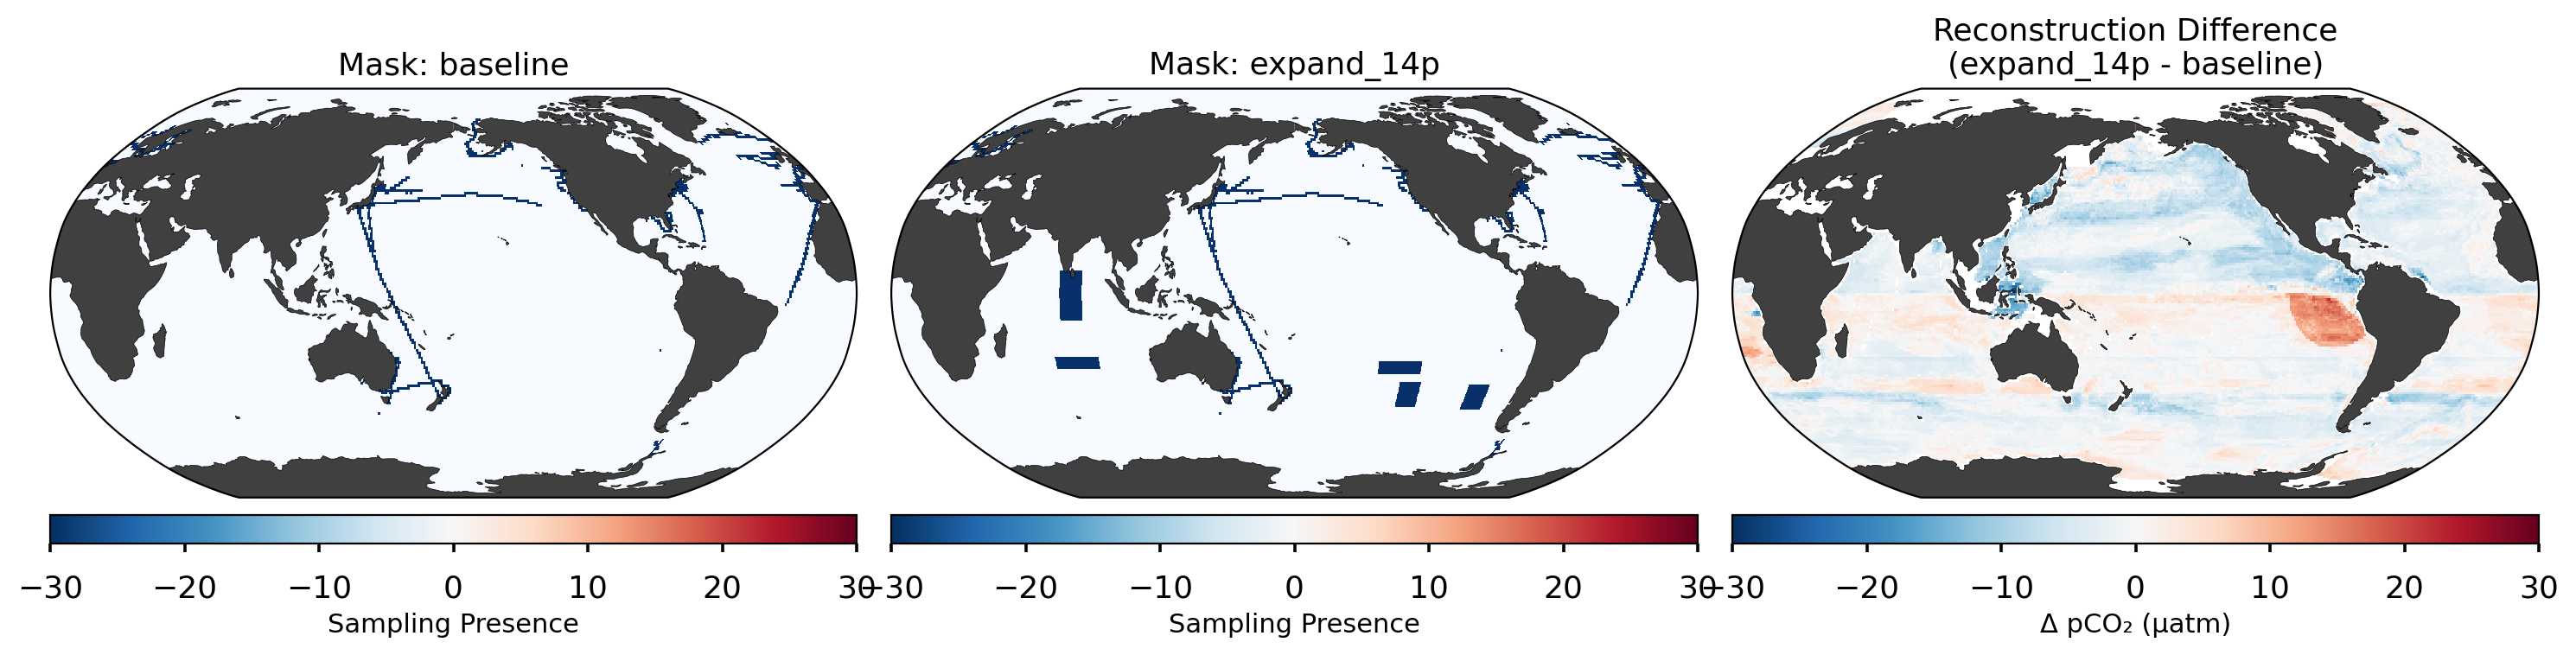

/tmp/ipykernel_64/991563459.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_mask = cm.get_cmap(cmap_mask)
/tmp/ipykernel_64/991563459.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_diff = cm.get_cmap(cmap_diff)


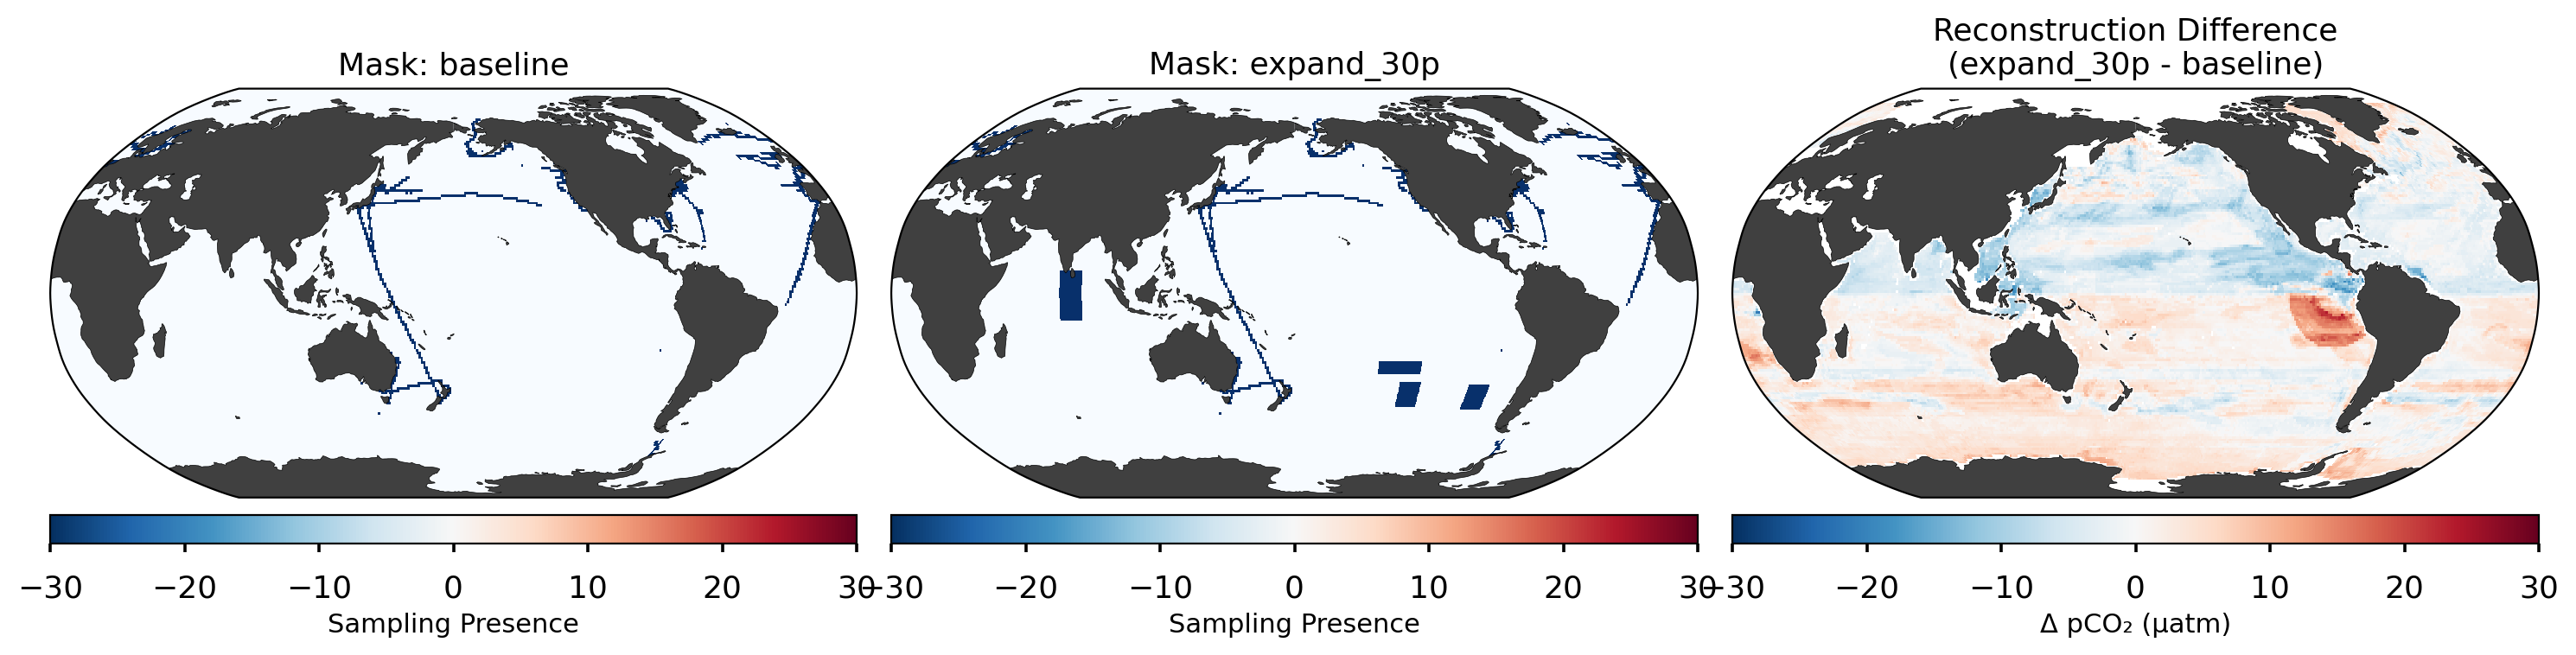

/tmp/ipykernel_64/991563459.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_mask = cm.get_cmap(cmap_mask)
/tmp/ipykernel_64/991563459.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_diff = cm.get_cmap(cmap_diff)


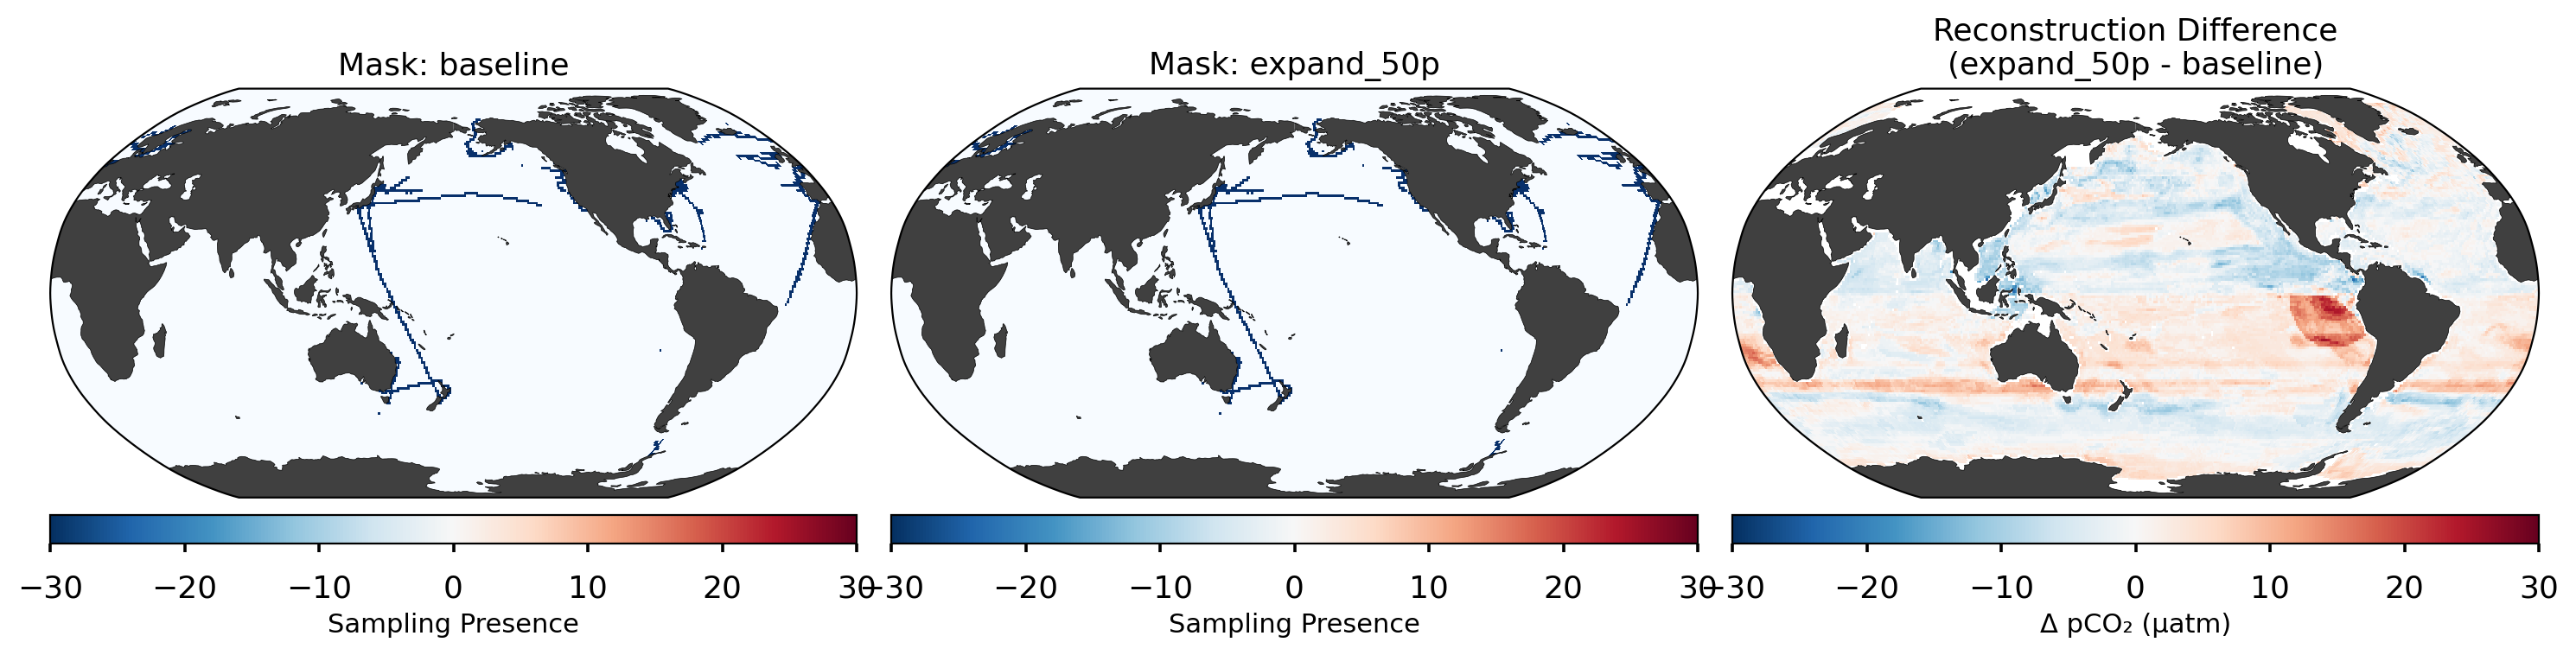

In [346]:
plot_monthly_comparison_panel(
    mask_name_1="baseline",
    mask_name_2="densify_mean_pattern",
    mask_data_dict=mask_data_dict,
    selected_mems_dict=selected_mems_dict,
    ensemble_dir=ensemble_dir,
    output_dir=output_dir,
    dates=dates,
    init_date=init_date,
    fin_date=fin_date,
    chosen_time="2021-05",
)

plot_monthly_comparison_panel(
    mask_name_1="baseline",
    mask_name_2="densify_30p",
    mask_data_dict=mask_data_dict,
    selected_mems_dict=selected_mems_dict,
    ensemble_dir=ensemble_dir,
    output_dir=output_dir,
    dates=dates,
    init_date=init_date,
    fin_date=fin_date,
    chosen_time="2021-05",
)

plot_monthly_comparison_panel(
    mask_name_1="baseline",
    mask_name_2="densify_50p",
    mask_data_dict=mask_data_dict,
    selected_mems_dict=selected_mems_dict,
    ensemble_dir=ensemble_dir,
    output_dir=output_dir,
    dates=dates,
    init_date=init_date,
    fin_date=fin_date,
    chosen_time="2021-05",
)


plot_monthly_comparison_panel(
    mask_name_1="baseline",
    mask_name_2="expand_14p",
    mask_data_dict=mask_data_dict,
    selected_mems_dict=selected_mems_dict,
    ensemble_dir=ensemble_dir,
    output_dir=output_dir,
    dates=dates,
    init_date=init_date,
    fin_date=fin_date,
    chosen_time="2021-05",
)


plot_monthly_comparison_panel(
    mask_name_1="baseline",
    mask_name_2="expand_30p",
    mask_data_dict=mask_data_dict,
    selected_mems_dict=selected_mems_dict,
    ensemble_dir=ensemble_dir,
    output_dir=output_dir,
    dates=dates,
    init_date=init_date,
    fin_date=fin_date,
    chosen_time="2021-05",
)


plot_monthly_comparison_panel(
    mask_name_1="baseline",
    mask_name_2="expand_50p",
    mask_data_dict=mask_data_dict,
    selected_mems_dict=selected_mems_dict,
    ensemble_dir=ensemble_dir,
    output_dir=output_dir,
    dates=dates,
    init_date=init_date,
    fin_date=fin_date,
    chosen_time="2021-05",
)


### (ALREADY HAVE THIS SO DROPPED) Locations where sampling coverage changed

## (DROPPED REPLACE WITH P-VAL) Uncertainty Analysis